# Melhorando a baseline inicial com Feature Engineering

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Métricas e Utilitários
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Para lidar com desbalanceamento
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



Preparação dos dados, treinamento e avaliação de modelos simples para estabelecer uma linha de base de desempenho agora com alguma feature engineering (remoção de colunas e aplicação de escalonamento somente em variáveis numéricas contínuas)

In [2]:
# Dataset de treino original
train_url = 'https://raw.githubusercontent.com/Huangxiaojie2024/InterDIA/refs/heads/main/DataSet/DIA_trainingset_RDKit_descriptors.csv'
df_train_original = pd.read_csv(train_url)

# Dataset de treino limpo
df_train_cleaned = pd.read_csv("1.1.EDA-df_train-cleaned.csv")



# Separar features (X) e variável alvo (y)
X_cleaned = df_train_cleaned.drop(columns=['Label'])
X_original = df_train_original.drop(columns=['Label','SMILES'])
y = df_train_cleaned['Label']



Dividimos o dataset de treino em subconjuntos de treino e validação. 

Isso é cruccial para avaliar os modelos de forma justa antes de usar o dataset de teste final.

Usamos `stratify=y` para manter a mesma proporção de classes em ambos os subconjuntos.


In [3]:
def split_data(X, y):
    """ Função para dividir os dados em treino e validação com estratificação.
    Args:
        X (DataFrame): Features.
        y (Series): Variável alvo.  
    Returns:
        X_train, X_val, y_train, y_val: Dados divididos.
    """
    # Dividir o dataset de treino em subconjuntos de treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,    # 20% para validação
        random_state=42,  # Para reprodutibilidade
        stratify=y
    )
    return X_train, X_val, y_train, y_val



Função para avaliar modelos

In [4]:
def avaliar_modelo(model, X_val, y_val, model_name="Modelo"):
    """
    Calcula e imprime as métricas de avaliação para um dado modelo.
    """
    print(f"--- Resultados para: {model_name} ---")

    # Fazer predições
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calcular métricas
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_pred)
    mcc = matthews_corrcoef(y_val, y_pred)

    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"AUC-PR (Precision-Recall): {pr_auc:.4f}") # Métrica importante para dados desbalanceados
    print(f"F1-Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}\n")


    # Imprimir relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_val, y_pred))

    # Plotar matriz de confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
    return {
        "model_name": model_name,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        'f1': f1,
        "mcc": mcc
    }



Vamos recuperar o que foi persistido durante a Análise Exploratória de Dados (AED) Inicial e:

1. Eliminar as features com dados constantes.
2. Eliminar as features com alta correlação com outras mantendo 1 feature representativa da informação.
3. Aplicar Escalonamento adequado a depender do tipo de variável.

In [5]:
import ast

def get_numeric_categoric_features(X_train):
    """ Retorna listas de features numéricas e categóricas com base no resumo do EDA. 

    """
    def safe_literal_eval(val):
        """Safely evaluate string representations of lists, handling special cases."""
        if val == 'Nenhuma' or pd.isna(val):
            return []
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            # If it's not a proper list string, return as single item list
            return [val] if val else []


    # Carregar o resumo das features do EDA
    df_eda_info = pd.read_csv("1.1.EDA-df_summary_types.csv")
    # Aplicar a função de avaliação literal segura para transformar em listas
    df_eda_info['Features'] = df_eda_info['Features'].apply(safe_literal_eval)
    # Separar features numéricas das categóricas para aplicar escalonamento apenas às numéricas
    features_numeric = df_eda_info[df_eda_info['Tipo de Feature'] == 'numeric']['Features'].values[0]

    # Identificar quais features numéricas ainda existem após a limpeza
    numeric_cols_remaining = [col for col in features_numeric if col in X_train.columns]

    # Features categóricas/binárias (não numéricas)
    categorical_cols = [col for col in X_train.columns if col not in numeric_cols_remaining]
    
    return numeric_cols_remaining, categorical_cols

Vamos começar com uma regressão logística simples como baseline.

É esperado um desempenho modesto, mas serve como um ponto de referência para modelos mais complexos.

O desempenho deve ser melhor que o acaso, mas não necessariamente alto.

É esperado um desempenho relativamente bom para a classe majoritária (negativa), mas mais baixo para a minoritária (positiva).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FunctionTransformer
from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


def prepara_modelos(descricao_dataset="", preprocessor=FunctionTransformer(lambda x: x)): #Caso preprocessor não seja passado, ele é um dummy preprocessor, não altera nada.
    estimator = AdaBoostClassifier(random_state=42, 
                               estimator= DecisionTreeClassifier(random_state=42, max_depth=7),
                               #n_estimators=178,
                               #learning_rate=0.92,
                               algorithm='SAMME')

    modelos = [
        (descricao_dataset, "Regressão Logística", LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)),
        (descricao_dataset, "LogisticRegression Ponderado", LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000, n_jobs=-1)),
        (descricao_dataset, "LightGBM", lgb.LGBMClassifier(random_state=42, n_jobs=-1)),
        (descricao_dataset, "LightGBM RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=lgb.LGBMClassifier(random_state=42))),('classifier', lgb.LGBMClassifier(random_state=42, n_jobs=-1))])),
        (descricao_dataset, "LightGBM Ponderado", lgb.LGBMClassifier(class_weight='balanced', random_state=42)),
        (descricao_dataset, "LightGBM Ponderado RFE", ImbPipeline([("preprocessor", preprocessor), ('rfe', RFE(estimator=lgb.LGBMClassifier(random_state=42))),('classifier', lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])),
        (descricao_dataset, "LightGBM SMOTE", ImbPipeline([("preprocessor", preprocessor), ('smote', SMOTE(random_state=42)),('classifier', lgb.LGBMClassifier(random_state=42, n_jobs=-1))])),
        (descricao_dataset, "LightGBM SMOTE Ponderado", ImbPipeline([("preprocessor", preprocessor), ('smote', SMOTE(random_state=42)),('classifier', lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])),
        (descricao_dataset, "LightGBM SMOTE RFE", ImbPipeline([("preprocessor", preprocessor), ('rfe', RFE(estimator=lgb.LGBMClassifier(random_state=42))),('classifier', lgb.LGBMClassifier(random_state=42, n_jobs=-1))])),
        (descricao_dataset, "LightGBM SMOTE Ponderado RFE", ImbPipeline([("preprocessor", preprocessor), ('smote', SMOTE(random_state=42)),('rfe', RFE(estimator=lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1))),('classifier', lgb.LGBMClassifier(class_weight='balanced', random_state=42))])),
        (descricao_dataset, "EasyEnsemble", ImbPipeline([("preprocessor", preprocessor),('classifier', EasyEnsembleClassifier(random_state=42, estimator=estimator, n_jobs=-1))])),
        (descricao_dataset, "EasyEnsemble RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=lgb.LGBMClassifier(random_state=42))),('classifier', EasyEnsembleClassifier(random_state=42, estimator=estimator, n_jobs=-1))])),
        (descricao_dataset, "EasyEnsemble", ImbPipeline([("preprocessor", preprocessor),('classifier', EasyEnsembleClassifier(random_state=42, estimator=estimator, n_jobs=-1))])),
        (descricao_dataset, "EasyEnsemble RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=lgb.LGBMClassifier(random_state=42))),('classifier', EasyEnsembleClassifier(random_state=42, estimator=estimator, n_jobs=-1))])),
        (descricao_dataset, "RUSBoost", ImbPipeline([("preprocessor", preprocessor),('classifier', RUSBoostClassifier(random_state=42, n_estimators=10, estimator=estimator))])),
        (descricao_dataset, "RUSBoost RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=lgb.LGBMClassifier(random_state=42))),('classifier', RUSBoostClassifier(random_state=42, n_estimators=10, estimator=estimator))])),
        (descricao_dataset, "KNN", ImbPipeline([("preprocessor", preprocessor),('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=10))])),
        (descricao_dataset, "RandomForest", ImbPipeline([("preprocessor", preprocessor),('classifier', RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))])),
        (descricao_dataset, "RandomForest RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))),('classifier', RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))])),
        (descricao_dataset, "BalancedRandomForest", ImbPipeline([("preprocessor", preprocessor),('classifier', BalancedRandomForestClassifier(n_jobs=-1, random_state=42))])),
        (descricao_dataset, "BalancedRandomForest RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))),('classifier', BalancedRandomForestClassifier(n_jobs=-1, random_state=42))])),
        (descricao_dataset, "XGBoost", ImbPipeline([("preprocessor", preprocessor),('classifier', XGBClassifier(n_jobs=-1, random_state=42))])),
        (descricao_dataset, "XGBoost RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=42))),('classifier', XGBClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))])),
        (descricao_dataset, "CatBoost", ImbPipeline([("preprocessor", preprocessor),('classifier', CatBoostClassifier(random_state=42, logging_level='Silent'))])),
        (descricao_dataset, "CatBoost RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))),('classifier', CatBoostClassifier(random_state=42, logging_level='Silent'))])),
        (descricao_dataset, "GradientBoosting", ImbPipeline([("preprocessor", preprocessor),('classifier', GradientBoostingClassifier(random_state=42))])),
        (descricao_dataset, "GradientBoosting RFE", ImbPipeline([("preprocessor", preprocessor),('rfe', RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))),('classifier', GradientBoostingClassifier(random_state=42))])),
    ]
    return modelos

/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/xgboost/compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [7]:
# Armazena os dfs com resultado de diversos experimentos
resultados_dfs = []


Treinando Original Regressão Logística...
--- Resultados para: Original - Regressão Logística ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

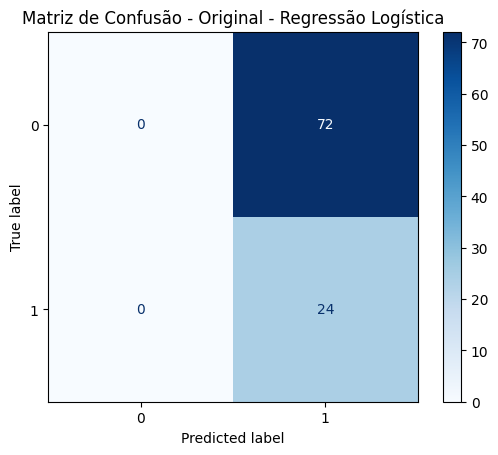


Treinando Original LogisticRegression Ponderado...
--- Resultados para: Original - LogisticRegression Ponderado ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

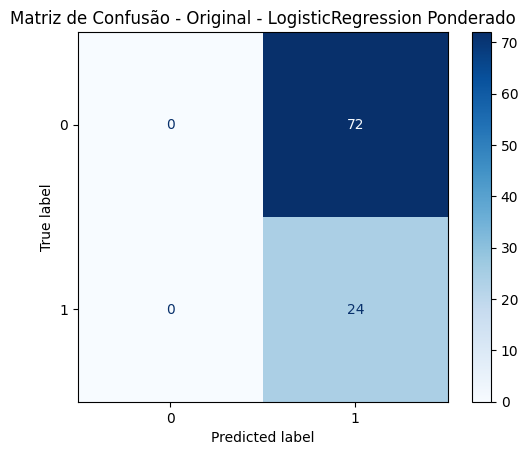


Treinando Original LightGBM...
--- Resultados para: Original - LightGBM ---
AUC-ROC: 0.9010
AUC-PR (Precision-Recall): 0.8072
F1-Score: 0.6809
MCC: 0.5777

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.70      0.67      0.68        24

    accuracy                           0.84        96
   macro avg       0.79      0.78      0.79        96
weighted avg       0.84      0.84      0.84        96



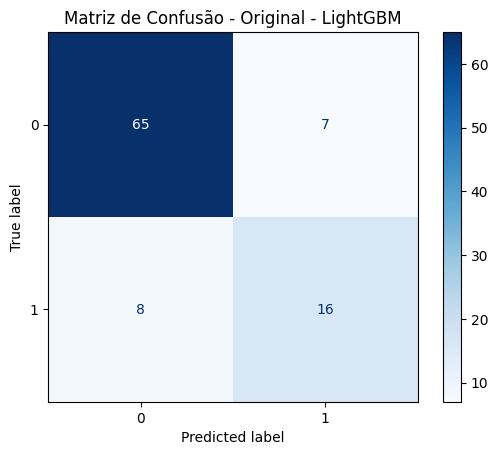


Treinando Original LightGBM RFE...
--- Resultados para: Original - LightGBM RFE ---
AUC-ROC: 0.8744
AUC-PR (Precision-Recall): 0.7742
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



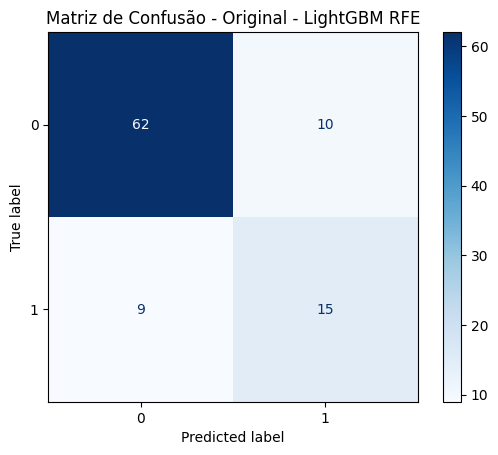


Treinando Original LightGBM Ponderado...
--- Resultados para: Original - LightGBM Ponderado ---
AUC-ROC: 0.8970
AUC-PR (Precision-Recall): 0.8226
F1-Score: 0.6923
MCC: 0.5822

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        72
           1       0.64      0.75      0.69        24

    accuracy                           0.83        96
   macro avg       0.78      0.81      0.79        96
weighted avg       0.84      0.83      0.84        96



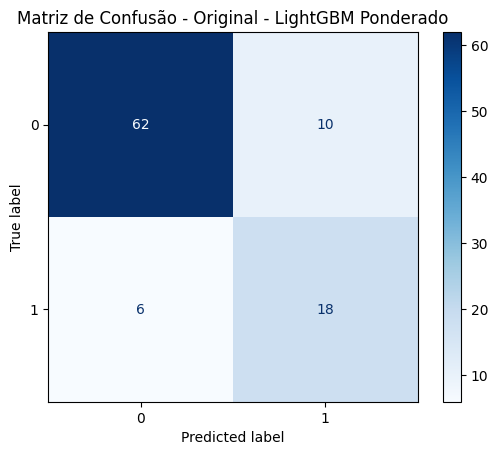


Treinando Original LightGBM Ponderado RFE...
--- Resultados para: Original - LightGBM Ponderado RFE ---
AUC-ROC: 0.8877
AUC-PR (Precision-Recall): 0.7908
F1-Score: 0.6296
MCC: 0.4930

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        72
           1       0.57      0.71      0.63        24

    accuracy                           0.79        96
   macro avg       0.73      0.76      0.74        96
weighted avg       0.81      0.79      0.80        96



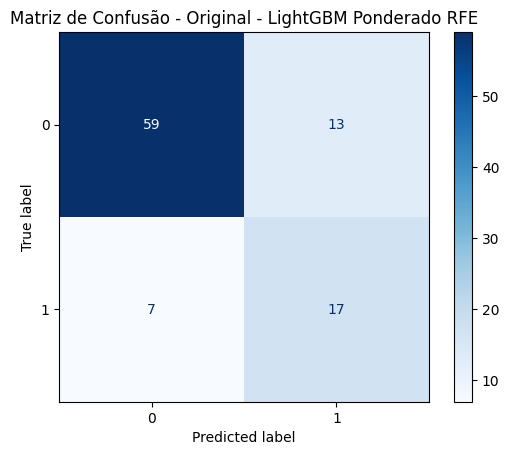


Treinando Original LightGBM SMOTE...
--- Resultados para: Original - LightGBM SMOTE ---
AUC-ROC: 0.8866
AUC-PR (Precision-Recall): 0.7763
F1-Score: 0.7037
MCC: 0.5968

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        72
           1       0.63      0.79      0.70        24

    accuracy                           0.83        96
   macro avg       0.78      0.82      0.79        96
weighted avg       0.85      0.83      0.84        96



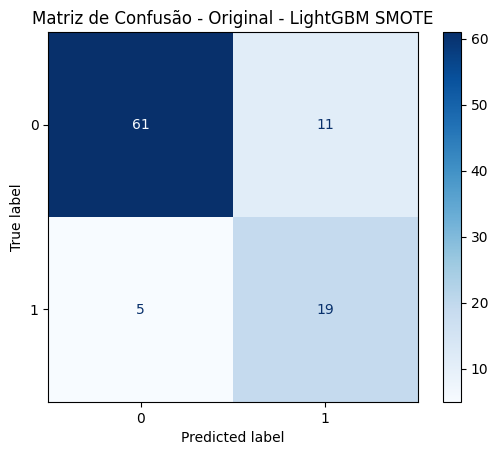


Treinando Original LightGBM SMOTE Ponderado...
--- Resultados para: Original - LightGBM SMOTE Ponderado ---
AUC-ROC: 0.8866
AUC-PR (Precision-Recall): 0.7763
F1-Score: 0.7037
MCC: 0.5968

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        72
           1       0.63      0.79      0.70        24

    accuracy                           0.83        96
   macro avg       0.78      0.82      0.79        96
weighted avg       0.85      0.83      0.84        96



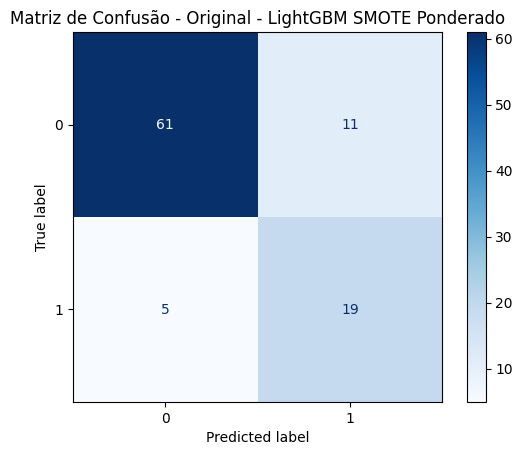


Treinando Original LightGBM SMOTE RFE...
--- Resultados para: Original - LightGBM SMOTE RFE ---
AUC-ROC: 0.8744
AUC-PR (Precision-Recall): 0.7742
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



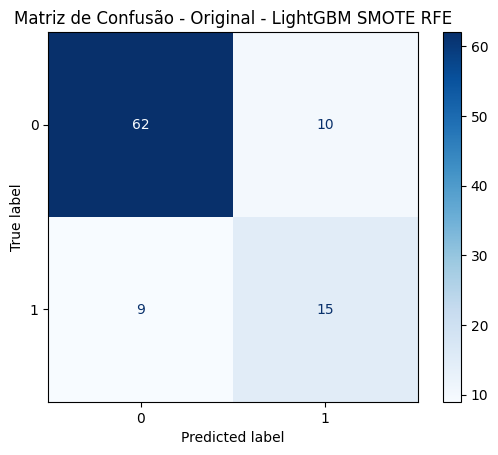


Treinando Original LightGBM SMOTE Ponderado RFE...
--- Resultados para: Original - LightGBM SMOTE Ponderado RFE ---
AUC-ROC: 0.8929
AUC-PR (Precision-Recall): 0.7576
F1-Score: 0.6275
MCC: 0.4949

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        72
           1       0.59      0.67      0.63        24

    accuracy                           0.80        96
   macro avg       0.74      0.76      0.75        96
weighted avg       0.81      0.80      0.81        96



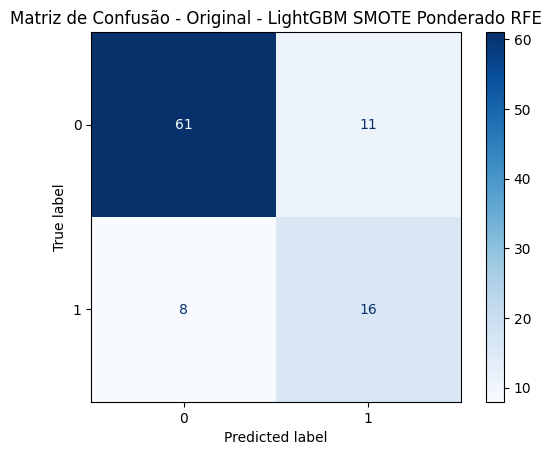


Treinando Original EasyEnsemble...
--- Resultados para: Original - EasyEnsemble ---
AUC-ROC: 0.8825
AUC-PR (Precision-Recall): 0.7258
F1-Score: 0.6571
MCC: 0.5538

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        72
           1       0.50      0.96      0.66        24

    accuracy                           0.75        96
   macro avg       0.74      0.82      0.73        96
weighted avg       0.86      0.75      0.77        96



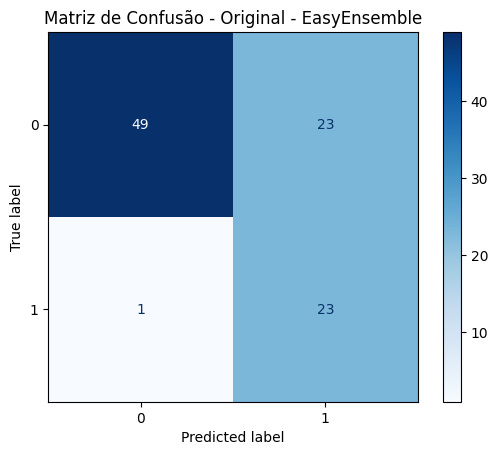


Treinando Original EasyEnsemble RFE...
--- Resultados para: Original - EasyEnsemble RFE ---
AUC-ROC: 0.8993
AUC-PR (Precision-Recall): 0.7490
F1-Score: 0.6349
MCC: 0.5021

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        72
           1       0.51      0.83      0.63        24

    accuracy                           0.76        96
   macro avg       0.72      0.78      0.73        96
weighted avg       0.83      0.76      0.78        96



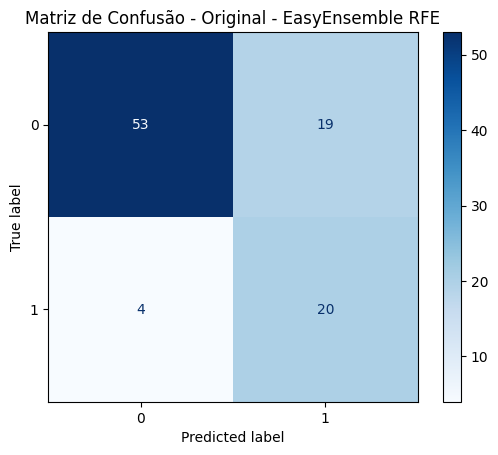


Treinando Original EasyEnsemble...
--- Resultados para: Original - EasyEnsemble ---
AUC-ROC: 0.8825
AUC-PR (Precision-Recall): 0.7258
F1-Score: 0.6571
MCC: 0.5538

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        72
           1       0.50      0.96      0.66        24

    accuracy                           0.75        96
   macro avg       0.74      0.82      0.73        96
weighted avg       0.86      0.75      0.77        96



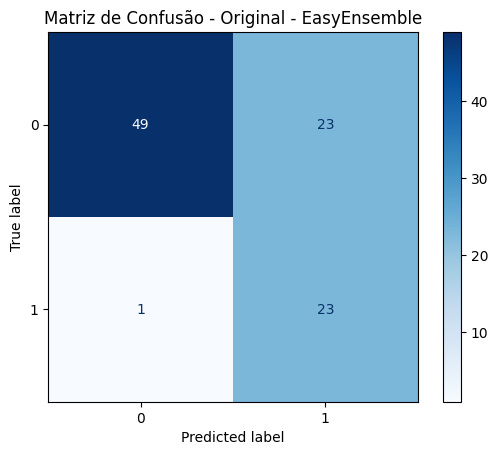


Treinando Original EasyEnsemble RFE...
--- Resultados para: Original - EasyEnsemble RFE ---
AUC-ROC: 0.8993
AUC-PR (Precision-Recall): 0.7490
F1-Score: 0.6349
MCC: 0.5021

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        72
           1       0.51      0.83      0.63        24

    accuracy                           0.76        96
   macro avg       0.72      0.78      0.73        96
weighted avg       0.83      0.76      0.78        96



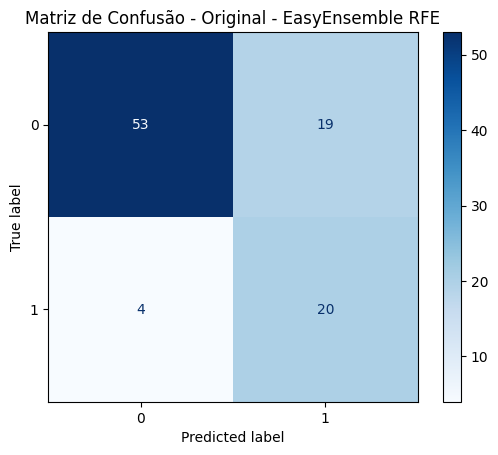


Treinando Original RUSBoost...
--- Resultados para: Original - RUSBoost ---
AUC-ROC: 0.8866
AUC-PR (Precision-Recall): 0.7902
F1-Score: 0.6269
MCC: 0.4959

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80        72
           1       0.49      0.88      0.63        24

    accuracy                           0.74        96
   macro avg       0.72      0.78      0.71        96
weighted avg       0.83      0.74      0.76        96



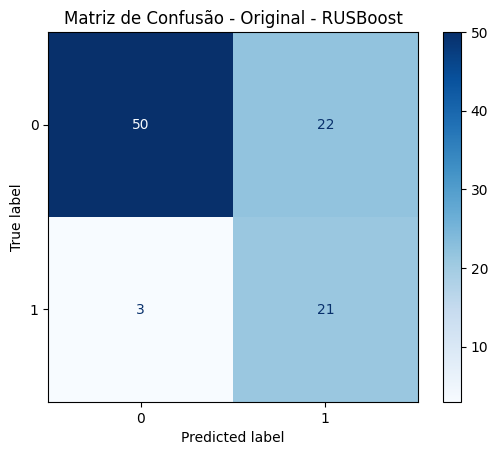


Treinando Original RUSBoost RFE...
--- Resultados para: Original - RUSBoost RFE ---
AUC-ROC: 0.8432
AUC-PR (Precision-Recall): 0.6822
F1-Score: 0.6230
MCC: 0.4819

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.75      0.82        72
           1       0.51      0.79      0.62        24

    accuracy                           0.76        96
   macro avg       0.71      0.77      0.72        96
weighted avg       0.81      0.76      0.77        96



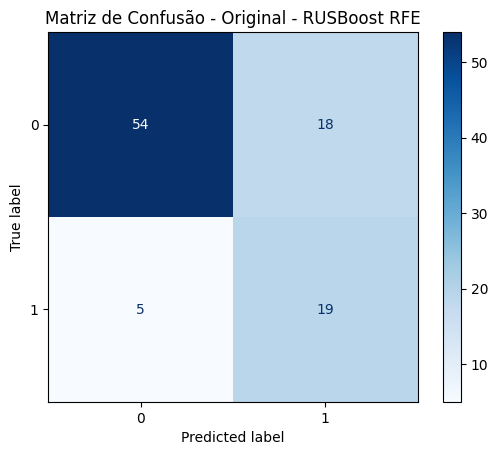


Treinando Original KNN...
--- Resultados para: Original - KNN ---
AUC-ROC: 0.5712
AUC-PR (Precision-Recall): 0.2753
F1-Score: 0.0714
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        72
           1       0.25      0.04      0.07        24

    accuracy                           0.73        96
   macro avg       0.50      0.50      0.46        96
weighted avg       0.62      0.73      0.65        96



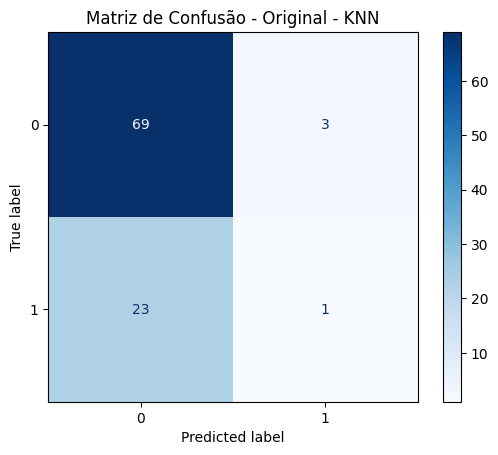


Treinando Original RandomForest...
--- Resultados para: Original - RandomForest ---
AUC-ROC: 0.8851
AUC-PR (Precision-Recall): 0.7468
F1-Score: 0.4848
MCC: 0.4746

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.99      0.89        72
           1       0.89      0.33      0.48        24

    accuracy                           0.82        96
   macro avg       0.85      0.66      0.69        96
weighted avg       0.83      0.82      0.79        96



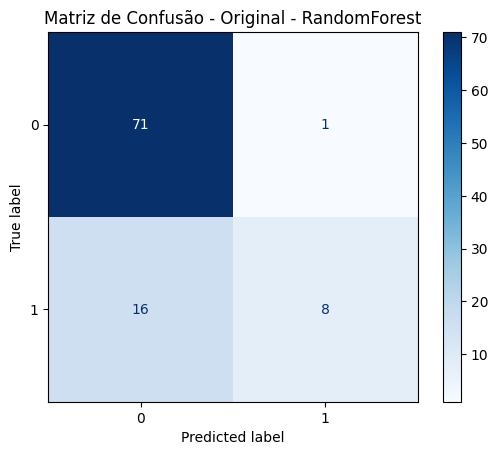


Treinando Original RandomForest RFE...
--- Resultados para: Original - RandomForest RFE ---
AUC-ROC: 0.8851
AUC-PR (Precision-Recall): 0.7779
F1-Score: 0.5556
MCC: 0.5092

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90        72
           1       0.83      0.42      0.56        24

    accuracy                           0.83        96
   macro avg       0.83      0.69      0.73        96
weighted avg       0.83      0.83      0.81        96



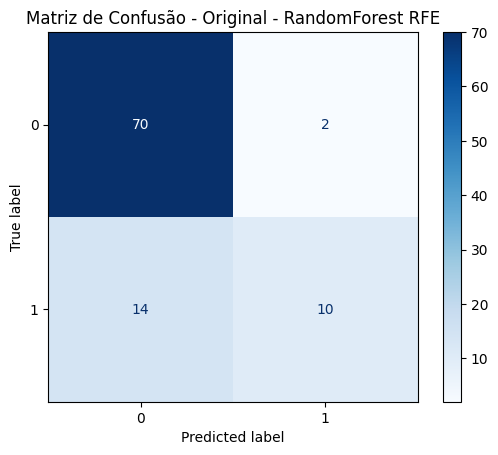


Treinando Original BalancedRandomForest...


/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

--- Resultados para: Original - BalancedRandomForest ---
AUC-ROC: 0.8247
AUC-PR (Precision-Recall): 0.6475
F1-Score: 0.5882
MCC: 0.4345

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        72
           1       0.45      0.83      0.59        24

    accuracy                           0.71        96
   macro avg       0.69      0.75      0.68        96
weighted avg       0.81      0.71      0.73        96



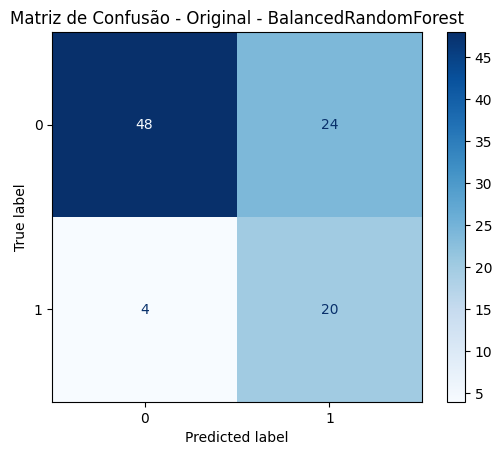


Treinando Original XGBoost...
[19:48:16] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Original - XGBoost ---
AUC-ROC: 0.8912
AUC-PR (Precision-Recall): 0.7753
F1-Score: 0.6977
MCC: 0.6189

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        72
           1       0.79      0.62      0.70        24

    accuracy                           0.86        96
   macro avg       0.84      0.78      0.81        96
weighted avg       0.86      0.86      0.86        96



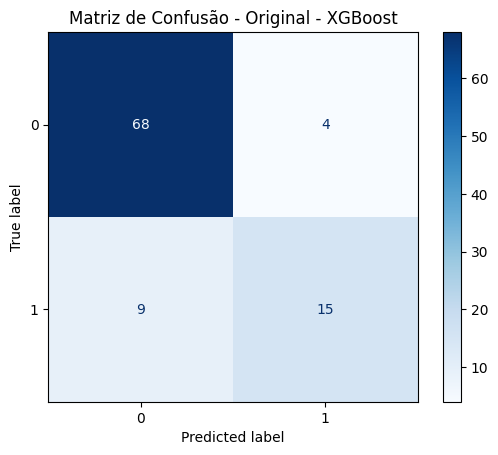


Treinando Original XGBoost RFE...
[19:49:05] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Original - XGBoost RFE ---
AUC-ROC: 0.9103
AUC-PR (Precision-Recall): 0.8109
F1-Score: 0.7451
MCC: 0.6554

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        72
           1       0.70      0.79      0.75        24

    accuracy                           0.86        96
   macro avg       0.82      0.84      0.83        96
weighted avg       0.87      0.86      0.87        96



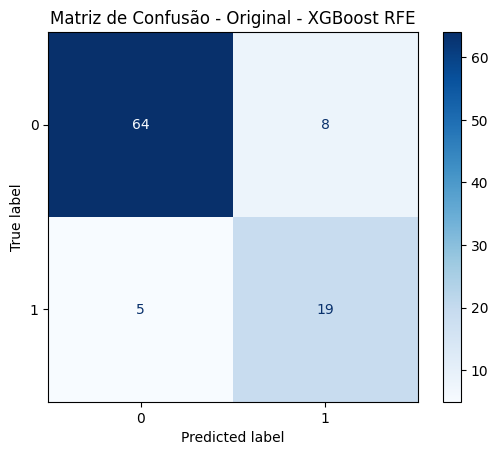


Treinando Original CatBoost...
--- Resultados para: Original - CatBoost ---
AUC-ROC: 0.8837
AUC-PR (Precision-Recall): 0.7781
F1-Score: 0.5946
MCC: 0.5449

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        72
           1       0.85      0.46      0.59        24

    accuracy                           0.84        96
   macro avg       0.84      0.72      0.75        96
weighted avg       0.84      0.84      0.83        96



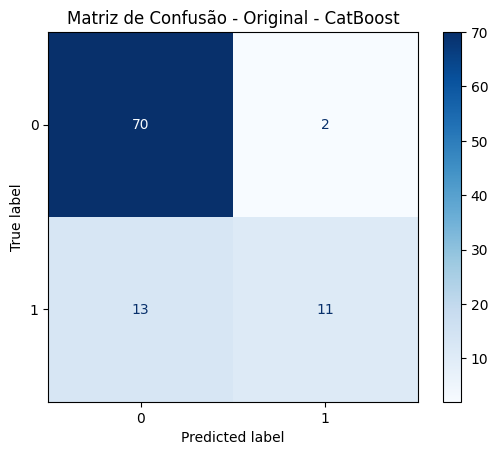


Treinando Original CatBoost RFE...
--- Resultados para: Original - CatBoost RFE ---
AUC-ROC: 0.8791
AUC-PR (Precision-Recall): 0.7527
F1-Score: 0.5946
MCC: 0.5449

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        72
           1       0.85      0.46      0.59        24

    accuracy                           0.84        96
   macro avg       0.84      0.72      0.75        96
weighted avg       0.84      0.84      0.83        96



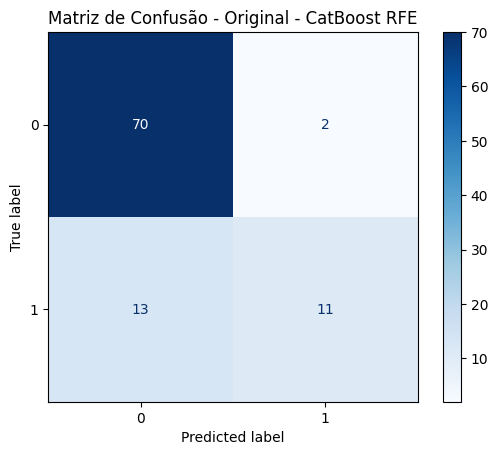


Treinando Original GradientBoosting...
--- Resultados para: Original - GradientBoosting ---
AUC-ROC: 0.9149
AUC-PR (Precision-Recall): 0.8104
F1-Score: 0.6977
MCC: 0.6189

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        72
           1       0.79      0.62      0.70        24

    accuracy                           0.86        96
   macro avg       0.84      0.78      0.81        96
weighted avg       0.86      0.86      0.86        96



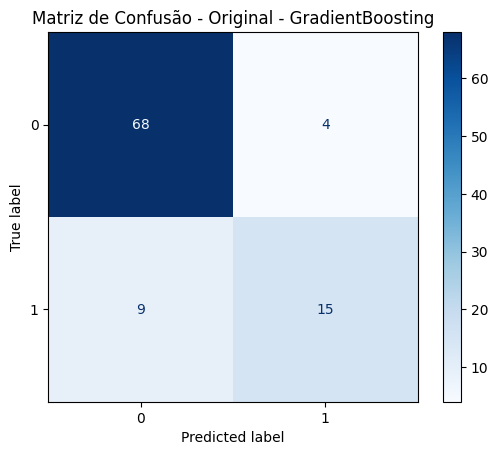


Treinando Original GradientBoosting RFE...
--- Resultados para: Original - GradientBoosting RFE ---
AUC-ROC: 0.8877
AUC-PR (Precision-Recall): 0.7453
F1-Score: 0.6667
MCC: 0.5556

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        72
           1       0.67      0.67      0.67        24

    accuracy                           0.83        96
   macro avg       0.78      0.78      0.78        96
weighted avg       0.83      0.83      0.83        96



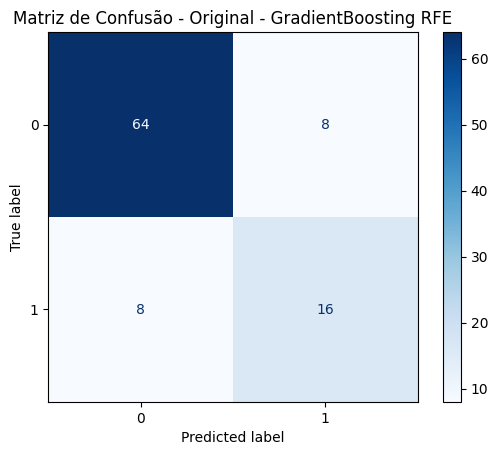

,model_name,roc_auc,pr_auc,f1,mcc
0,Original - XGBoost RFE,0.910301,0.810931,0.745098,0.655434
1,Original - GradientBoosting,0.914931,0.810432,0.697674,0.618872
2,Original - XGBoost,0.891204,0.775262,0.697674,0.618872
3,Original - LightGBM SMOTE,0.886574,0.776283,0.703704,0.596849
4,Original - LightGBM SMOTE Ponderado,0.886574,0.776283,0.703704,0.596849
5,Original - LightGBM Ponderado,0.896991,0.822588,0.692308,0.582182
6,Original - LightGBM,0.901042,0.807223,0.680851,0.577694
7,Original - GradientBoosting RFE,0.887731,0.745274,0.666667,0.555556
8,Original - EasyEnsemble,0.882523,0.725764,0.657143,0.553775
9,Original - EasyEnsemble,0.882523,0.725764,0.657143,0.553775


In [8]:
# Treinar e avaliar modelos nos dados originais
resultados = []
X_train_original, X_val_original, y_train_original, y_val_original = split_data(X_original, y)
X_train_scaled = X_train_original.copy()
X_val_scaled = X_val_original.copy()
#X_train_scaled, X_val_scaled = aplicar_escalonamento(X_train_original, X_val_original)
for descricao_dataset, model_name, model in prepara_modelos(descricao_dataset="Original"):
    print(f"\nTreinando {descricao_dataset} {model_name}...")
    model.fit(X_train_scaled, y_train_original)
    resultado = avaliar_modelo(model, X_val_scaled, y_val_original, model_name=f"{descricao_dataset} - {model_name}")
    resultados.append(resultado)

df_temp = pd.DataFrame(resultados).sort_values('mcc', ascending=False).reset_index(drop=True)
resultados_dfs.append(df_temp)
df_temp



Treinando Original Escalonado Regressão Logística...
--- Resultados para: Original Escalonado - Regressão Logística ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

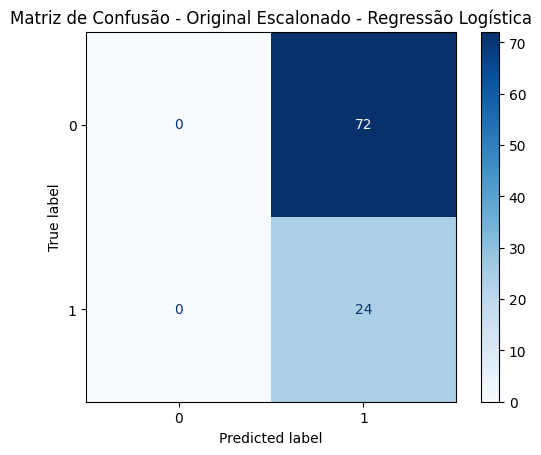


Treinando Original Escalonado LogisticRegression Ponderado...
--- Resultados para: Original Escalonado - LogisticRegression Ponderado ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

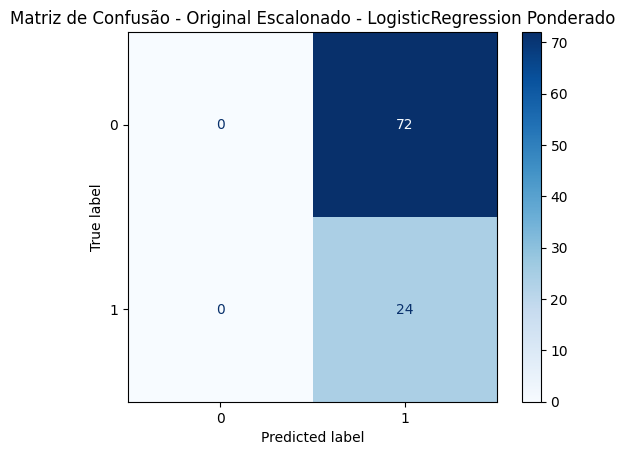


Treinando Original Escalonado LightGBM...
--- Resultados para: Original Escalonado - LightGBM ---
AUC-ROC: 0.9010
AUC-PR (Precision-Recall): 0.8072
F1-Score: 0.6809
MCC: 0.5777

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.70      0.67      0.68        24

    accuracy                           0.84        96
   macro avg       0.79      0.78      0.79        96
weighted avg       0.84      0.84      0.84        96



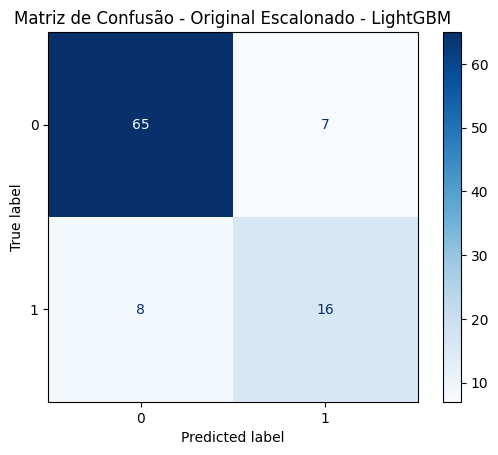


Treinando Original Escalonado LightGBM RFE...
--- Resultados para: Original Escalonado - LightGBM RFE ---
AUC-ROC: 0.8744
AUC-PR (Precision-Recall): 0.7742
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



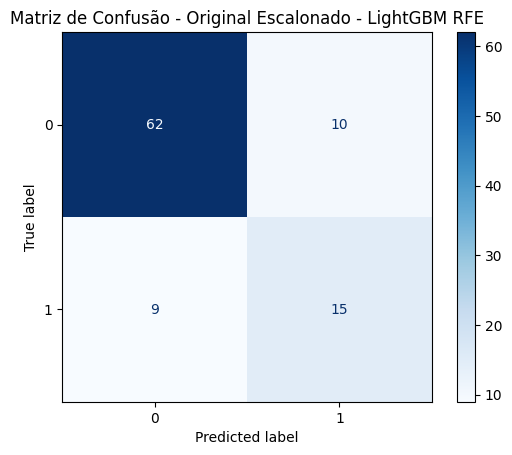


Treinando Original Escalonado LightGBM Ponderado...
--- Resultados para: Original Escalonado - LightGBM Ponderado ---
AUC-ROC: 0.8970
AUC-PR (Precision-Recall): 0.8226
F1-Score: 0.6923
MCC: 0.5822

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        72
           1       0.64      0.75      0.69        24

    accuracy                           0.83        96
   macro avg       0.78      0.81      0.79        96
weighted avg       0.84      0.83      0.84        96



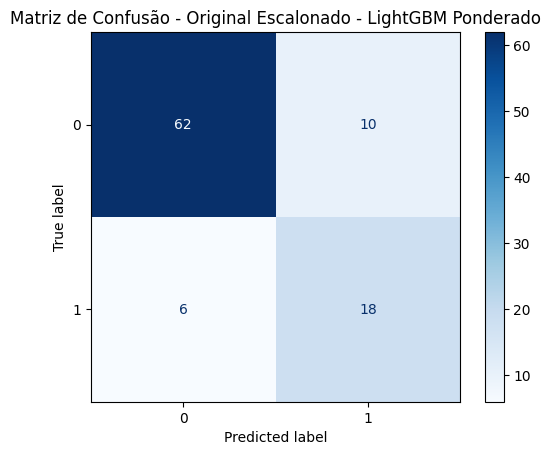


Treinando Original Escalonado LightGBM Ponderado RFE...
--- Resultados para: Original Escalonado - LightGBM Ponderado RFE ---
AUC-ROC: 0.8877
AUC-PR (Precision-Recall): 0.7908
F1-Score: 0.6296
MCC: 0.4930

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        72
           1       0.57      0.71      0.63        24

    accuracy                           0.79        96
   macro avg       0.73      0.76      0.74        96
weighted avg       0.81      0.79      0.80        96



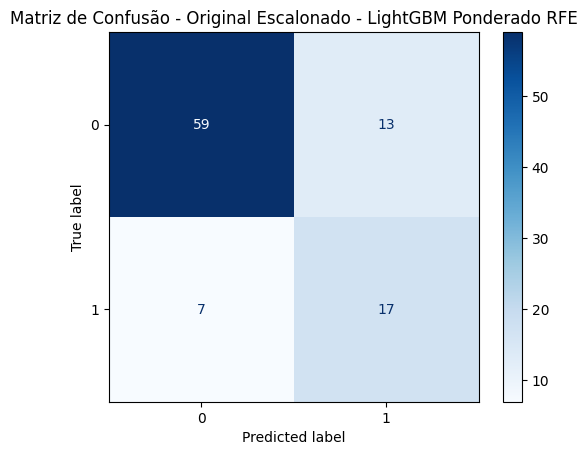


Treinando Original Escalonado LightGBM SMOTE...
--- Resultados para: Original Escalonado - LightGBM SMOTE ---
AUC-ROC: 0.8866
AUC-PR (Precision-Recall): 0.7763
F1-Score: 0.7037
MCC: 0.5968

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        72
           1       0.63      0.79      0.70        24

    accuracy                           0.83        96
   macro avg       0.78      0.82      0.79        96
weighted avg       0.85      0.83      0.84        96



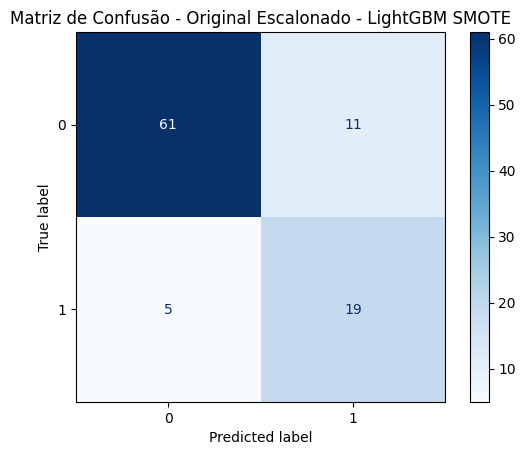


Treinando Original Escalonado LightGBM SMOTE Ponderado...
--- Resultados para: Original Escalonado - LightGBM SMOTE Ponderado ---
AUC-ROC: 0.8866
AUC-PR (Precision-Recall): 0.7763
F1-Score: 0.7037
MCC: 0.5968

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        72
           1       0.63      0.79      0.70        24

    accuracy                           0.83        96
   macro avg       0.78      0.82      0.79        96
weighted avg       0.85      0.83      0.84        96



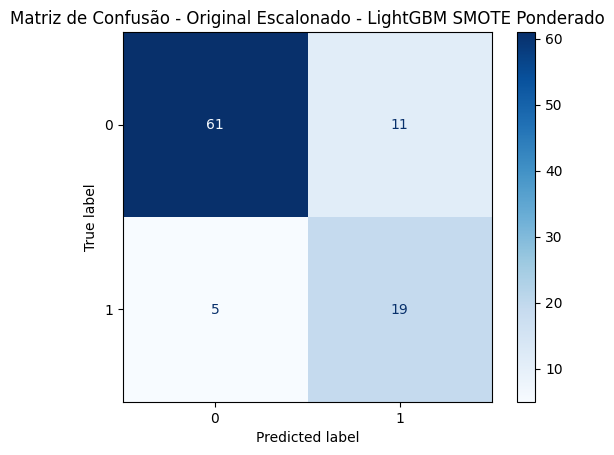


Treinando Original Escalonado LightGBM SMOTE RFE...
--- Resultados para: Original Escalonado - LightGBM SMOTE RFE ---
AUC-ROC: 0.8744
AUC-PR (Precision-Recall): 0.7742
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



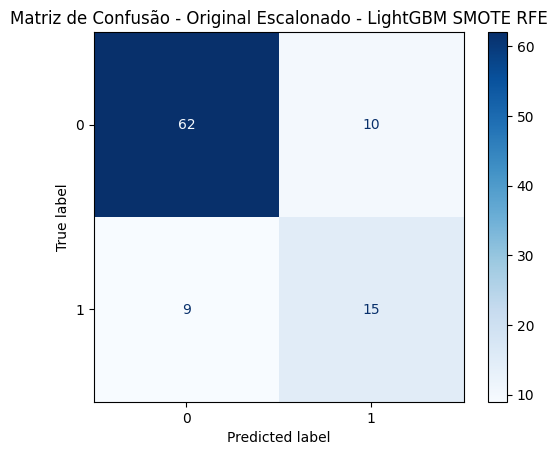


Treinando Original Escalonado LightGBM SMOTE Ponderado RFE...
--- Resultados para: Original Escalonado - LightGBM SMOTE Ponderado RFE ---
AUC-ROC: 0.8929
AUC-PR (Precision-Recall): 0.7576
F1-Score: 0.6275
MCC: 0.4949

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        72
           1       0.59      0.67      0.63        24

    accuracy                           0.80        96
   macro avg       0.74      0.76      0.75        96
weighted avg       0.81      0.80      0.81        96



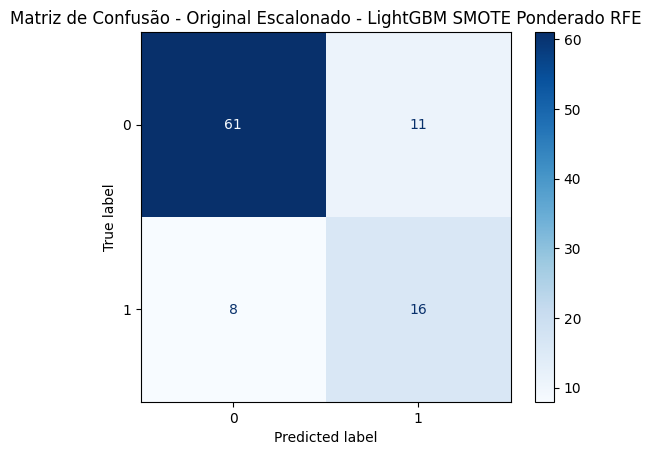


Treinando Original Escalonado EasyEnsemble...
--- Resultados para: Original Escalonado - EasyEnsemble ---
AUC-ROC: 0.8825
AUC-PR (Precision-Recall): 0.7258
F1-Score: 0.6571
MCC: 0.5538

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        72
           1       0.50      0.96      0.66        24

    accuracy                           0.75        96
   macro avg       0.74      0.82      0.73        96
weighted avg       0.86      0.75      0.77        96



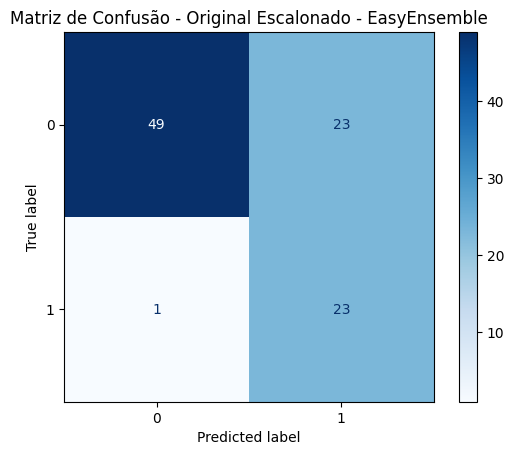


Treinando Original Escalonado EasyEnsemble RFE...
--- Resultados para: Original Escalonado - EasyEnsemble RFE ---
AUC-ROC: 0.8993
AUC-PR (Precision-Recall): 0.7490
F1-Score: 0.6349
MCC: 0.5021

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        72
           1       0.51      0.83      0.63        24

    accuracy                           0.76        96
   macro avg       0.72      0.78      0.73        96
weighted avg       0.83      0.76      0.78        96



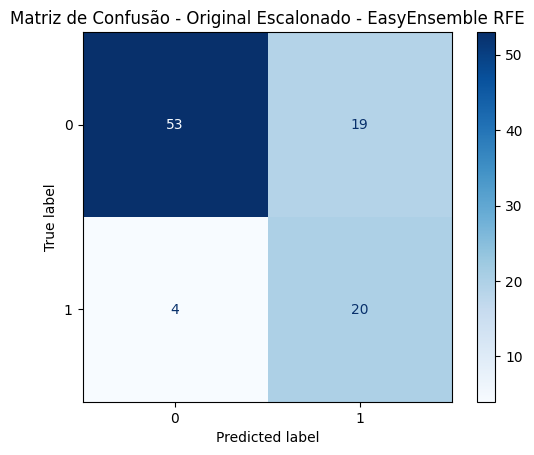


Treinando Original Escalonado EasyEnsemble...
--- Resultados para: Original Escalonado - EasyEnsemble ---
AUC-ROC: 0.8825
AUC-PR (Precision-Recall): 0.7258
F1-Score: 0.6571
MCC: 0.5538

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        72
           1       0.50      0.96      0.66        24

    accuracy                           0.75        96
   macro avg       0.74      0.82      0.73        96
weighted avg       0.86      0.75      0.77        96



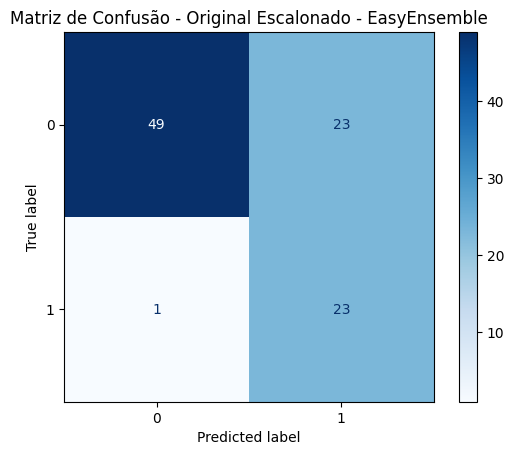


Treinando Original Escalonado EasyEnsemble RFE...
--- Resultados para: Original Escalonado - EasyEnsemble RFE ---
AUC-ROC: 0.8993
AUC-PR (Precision-Recall): 0.7490
F1-Score: 0.6349
MCC: 0.5021

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        72
           1       0.51      0.83      0.63        24

    accuracy                           0.76        96
   macro avg       0.72      0.78      0.73        96
weighted avg       0.83      0.76      0.78        96



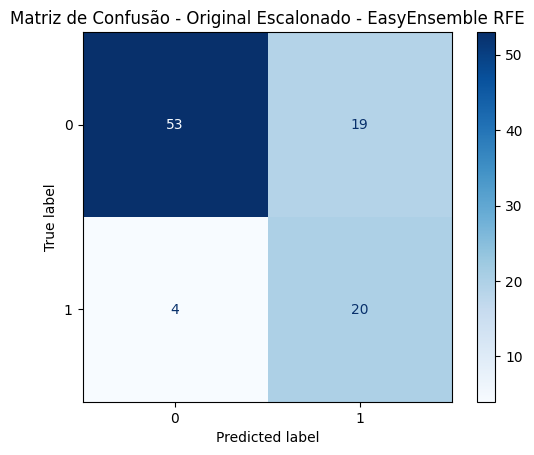


Treinando Original Escalonado RUSBoost...
--- Resultados para: Original Escalonado - RUSBoost ---
AUC-ROC: 0.8866
AUC-PR (Precision-Recall): 0.7902
F1-Score: 0.6269
MCC: 0.4959

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80        72
           1       0.49      0.88      0.63        24

    accuracy                           0.74        96
   macro avg       0.72      0.78      0.71        96
weighted avg       0.83      0.74      0.76        96



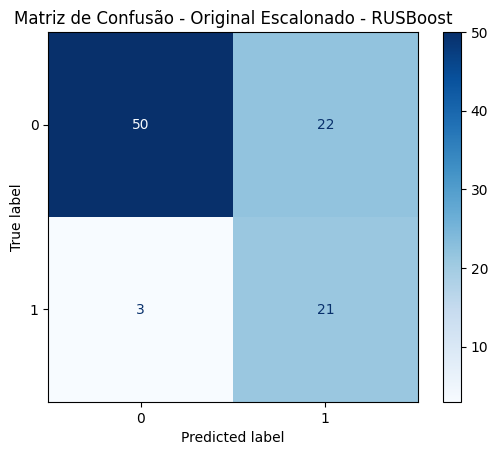


Treinando Original Escalonado RUSBoost RFE...
--- Resultados para: Original Escalonado - RUSBoost RFE ---
AUC-ROC: 0.8432
AUC-PR (Precision-Recall): 0.6822
F1-Score: 0.6230
MCC: 0.4819

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.75      0.82        72
           1       0.51      0.79      0.62        24

    accuracy                           0.76        96
   macro avg       0.71      0.77      0.72        96
weighted avg       0.81      0.76      0.77        96



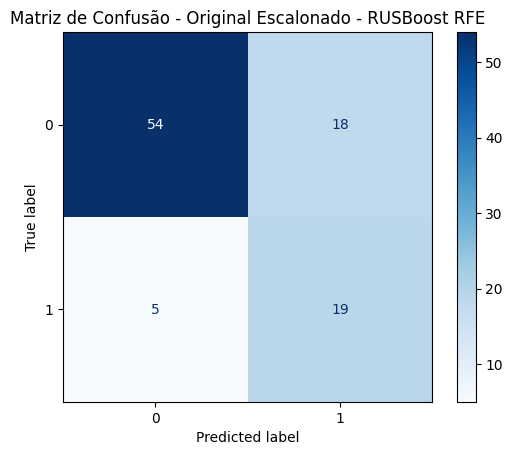


Treinando Original Escalonado KNN...
--- Resultados para: Original Escalonado - KNN ---
AUC-ROC: 0.5712
AUC-PR (Precision-Recall): 0.2753
F1-Score: 0.0714
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        72
           1       0.25      0.04      0.07        24

    accuracy                           0.73        96
   macro avg       0.50      0.50      0.46        96
weighted avg       0.62      0.73      0.65        96



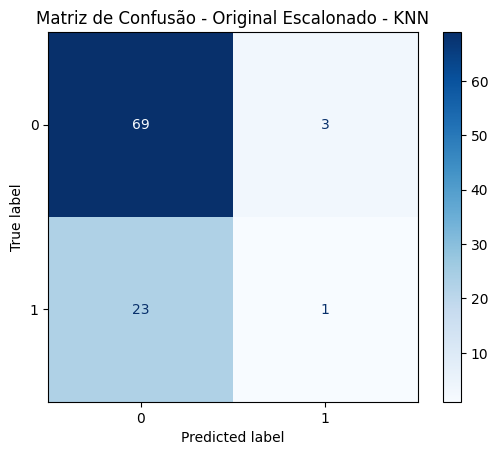


Treinando Original Escalonado RandomForest...
--- Resultados para: Original Escalonado - RandomForest ---
AUC-ROC: 0.8851
AUC-PR (Precision-Recall): 0.7468
F1-Score: 0.4848
MCC: 0.4746

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.99      0.89        72
           1       0.89      0.33      0.48        24

    accuracy                           0.82        96
   macro avg       0.85      0.66      0.69        96
weighted avg       0.83      0.82      0.79        96



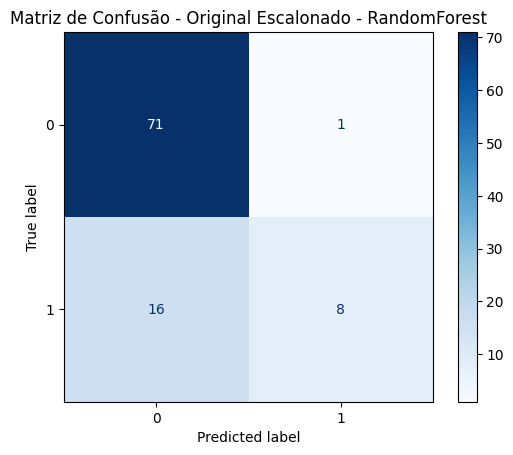


Treinando Original Escalonado RandomForest RFE...
--- Resultados para: Original Escalonado - RandomForest RFE ---
AUC-ROC: 0.8851
AUC-PR (Precision-Recall): 0.7779
F1-Score: 0.5556
MCC: 0.5092

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90        72
           1       0.83      0.42      0.56        24

    accuracy                           0.83        96
   macro avg       0.83      0.69      0.73        96
weighted avg       0.83      0.83      0.81        96



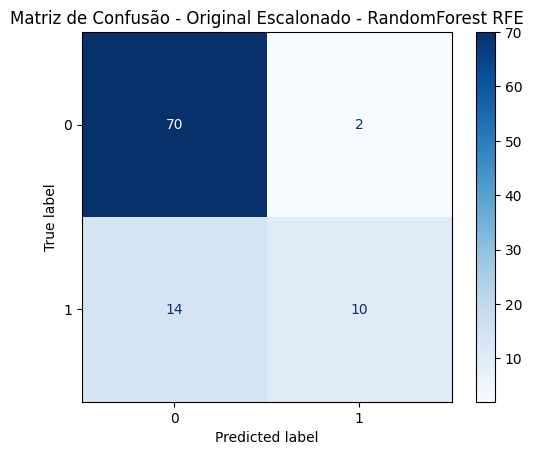


Treinando Original Escalonado BalancedRandomForest...


/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

--- Resultados para: Original Escalonado - BalancedRandomForest ---
AUC-ROC: 0.8247
AUC-PR (Precision-Recall): 0.6475
F1-Score: 0.5882
MCC: 0.4345

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        72
           1       0.45      0.83      0.59        24

    accuracy                           0.71        96
   macro avg       0.69      0.75      0.68        96
weighted avg       0.81      0.71      0.73        96



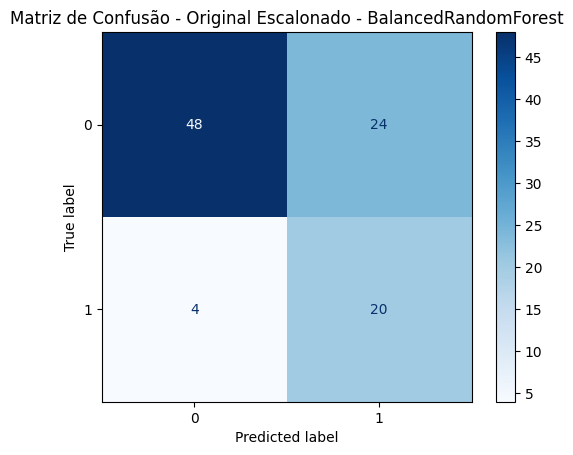


Treinando Original Escalonado XGBoost...
[19:57:14] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Original Escalonado - XGBoost ---
AUC-ROC: 0.8912
AUC-PR (Precision-Recall): 0.7753
F1-Score: 0.6977
MCC: 0.6189

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        72
           1       0.79      0.62      0.70        24

    accuracy                           0.86        96
   macro avg       0.84      0.78      0.81        96
weighted avg       0.86      0.86      0.86        96



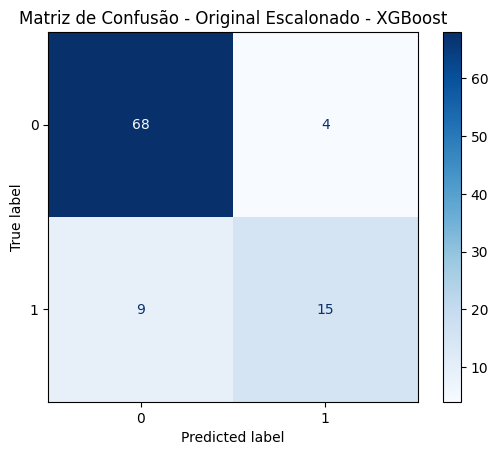


Treinando Original Escalonado XGBoost RFE...
[19:58:02] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Original Escalonado - XGBoost RFE ---
AUC-ROC: 0.9103
AUC-PR (Precision-Recall): 0.8109
F1-Score: 0.7451
MCC: 0.6554

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        72
           1       0.70      0.79      0.75        24

    accuracy                           0.86        96
   macro avg       0.82      0.84      0.83        96
weighted avg       0.87      0.86      0.87        96



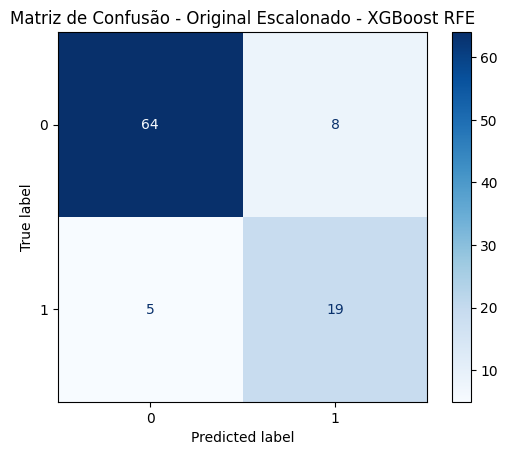


Treinando Original Escalonado CatBoost...
--- Resultados para: Original Escalonado - CatBoost ---
AUC-ROC: 0.8837
AUC-PR (Precision-Recall): 0.7781
F1-Score: 0.5946
MCC: 0.5449

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        72
           1       0.85      0.46      0.59        24

    accuracy                           0.84        96
   macro avg       0.84      0.72      0.75        96
weighted avg       0.84      0.84      0.83        96



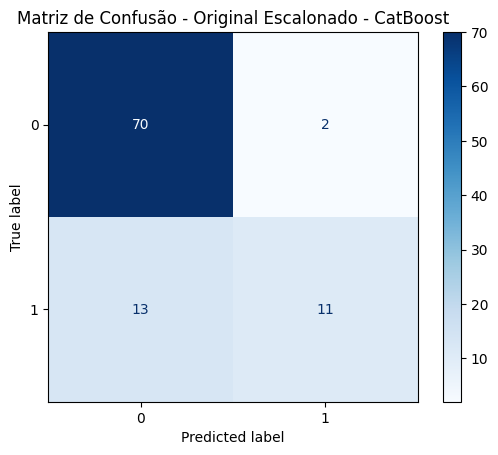


Treinando Original Escalonado CatBoost RFE...
--- Resultados para: Original Escalonado - CatBoost RFE ---
AUC-ROC: 0.8791
AUC-PR (Precision-Recall): 0.7527
F1-Score: 0.5946
MCC: 0.5449

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        72
           1       0.85      0.46      0.59        24

    accuracy                           0.84        96
   macro avg       0.84      0.72      0.75        96
weighted avg       0.84      0.84      0.83        96



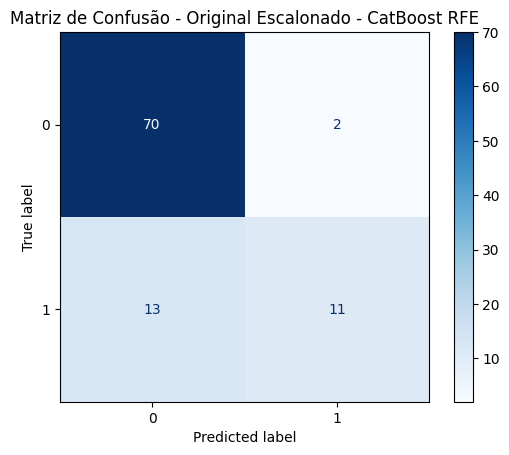


Treinando Original Escalonado GradientBoosting...
--- Resultados para: Original Escalonado - GradientBoosting ---
AUC-ROC: 0.9149
AUC-PR (Precision-Recall): 0.8104
F1-Score: 0.6977
MCC: 0.6189

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        72
           1       0.79      0.62      0.70        24

    accuracy                           0.86        96
   macro avg       0.84      0.78      0.81        96
weighted avg       0.86      0.86      0.86        96



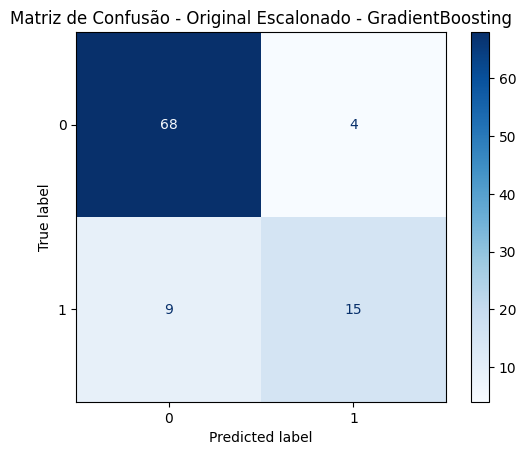


Treinando Original Escalonado GradientBoosting RFE...
--- Resultados para: Original Escalonado - GradientBoosting RFE ---
AUC-ROC: 0.8877
AUC-PR (Precision-Recall): 0.7453
F1-Score: 0.6667
MCC: 0.5556

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        72
           1       0.67      0.67      0.67        24

    accuracy                           0.83        96
   macro avg       0.78      0.78      0.78        96
weighted avg       0.83      0.83      0.83        96



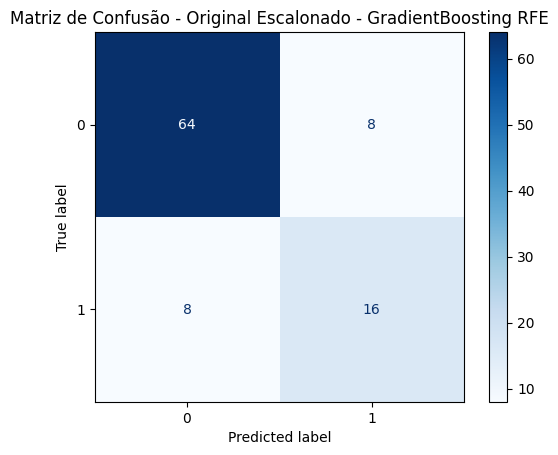

,model_name,roc_auc,pr_auc,f1,mcc
0,Original Escalonado - XGBoost RFE,0.910301,0.810931,0.745098,0.655434
1,Original Escalonado - GradientBoosting,0.914931,0.810432,0.697674,0.618872
2,Original Escalonado - XGBoost,0.891204,0.775262,0.697674,0.618872
3,Original Escalonado - LightGBM SMOTE,0.886574,0.776283,0.703704,0.596849
4,Original Escalonado - LightGBM SMOTE Ponderado,0.886574,0.776283,0.703704,0.596849
5,Original Escalonado - LightGBM Ponderado,0.896991,0.822588,0.692308,0.582182
6,Original Escalonado - LightGBM,0.901042,0.807223,0.680851,0.577694
7,Original Escalonado - GradientBoosting RFE,0.887731,0.745274,0.666667,0.555556
8,Original Escalonado - EasyEnsemble,0.882523,0.725764,0.657143,0.553775
9,Original Escalonado - EasyEnsemble,0.882523,0.725764,0.657143,0.553775


In [9]:
# Treinar e avaliar modelos nos dados originais
resultados = []
X_train_original, X_val_original, y_train_original, y_val_original = split_data(X_original, y)
X_train_scaled = X_train_original.copy()
X_val_scaled = X_val_original.copy()
#X_train_scaled, X_val_scaled = aplicar_escalonamento(X_train_original, X_val_original)
for descricao_dataset, model_name, model in prepara_modelos(descricao_dataset="Original Escalonado"):
    print(f"\nTreinando {descricao_dataset} {model_name}...")
    model.fit(X_train_scaled, y_train_original)
    resultado = avaliar_modelo(model, X_val_scaled, y_val_original, model_name=f"{descricao_dataset} - {model_name}")
    resultados.append(resultado)

df_temp = pd.DataFrame(resultados).sort_values('mcc', ascending=False).reset_index(drop=True)
resultados_dfs.append(df_temp)
df_temp



Treinando Regressão Logística...
--- Resultados para: Limpo - Regressão Logística ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

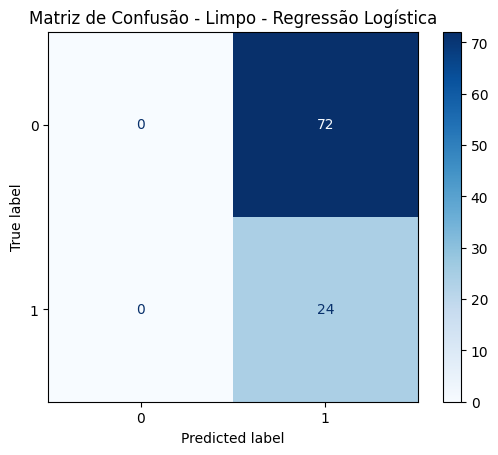


Treinando LogisticRegression Ponderado...
--- Resultados para: Limpo - LogisticRegression Ponderado ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

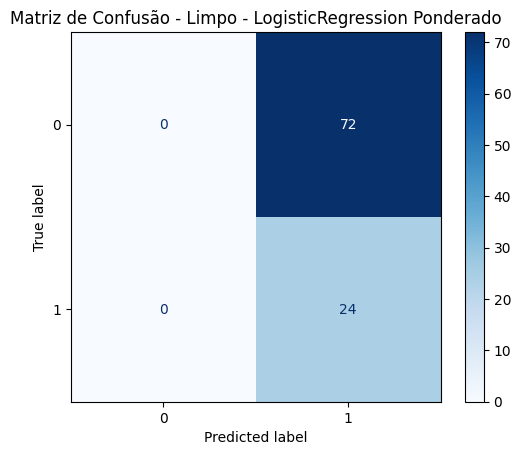


Treinando LightGBM...
--- Resultados para: Limpo - LightGBM ---
AUC-ROC: 0.8854
AUC-PR (Precision-Recall): 0.7791
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



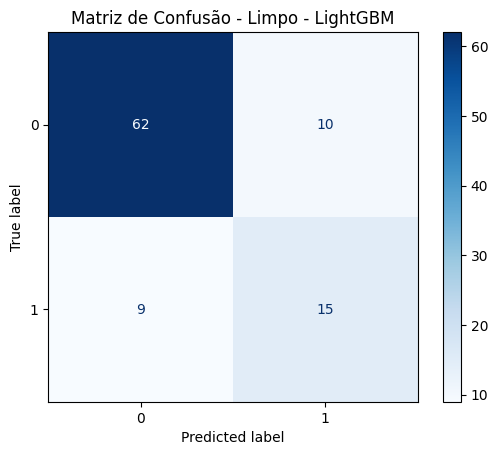


Treinando LightGBM RFE...
--- Resultados para: Limpo - LightGBM RFE ---
AUC-ROC: 0.8831
AUC-PR (Precision-Recall): 0.7668
F1-Score: 0.6000
MCC: 0.4601

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        72
           1       0.58      0.62      0.60        24

    accuracy                           0.79        96
   macro avg       0.72      0.74      0.73        96
weighted avg       0.80      0.79      0.79        96



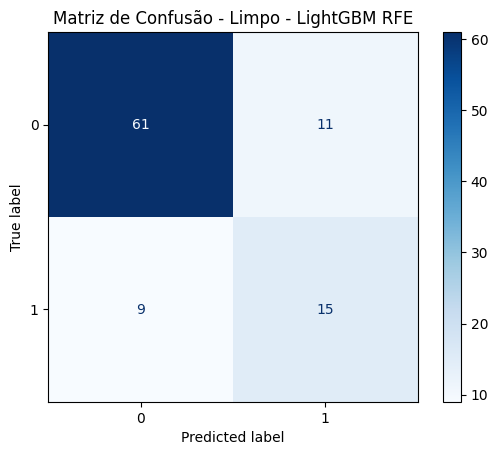


Treinando LightGBM Ponderado...
--- Resultados para: Limpo - LightGBM Ponderado ---
AUC-ROC: 0.9010
AUC-PR (Precision-Recall): 0.8184
F1-Score: 0.6667
MCC: 0.5484

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        72
           1       0.63      0.71      0.67        24

    accuracy                           0.82        96
   macro avg       0.76      0.78      0.77        96
weighted avg       0.83      0.82      0.83        96



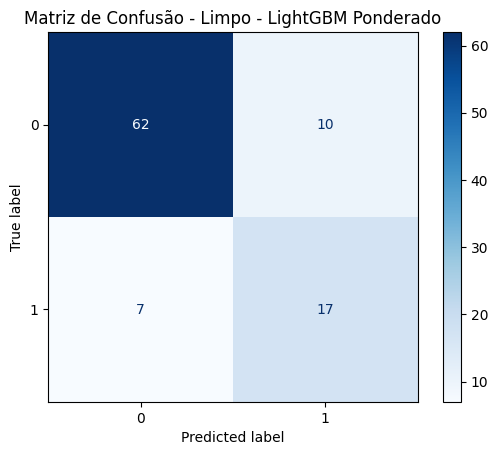


Treinando LightGBM Ponderado RFE...
--- Resultados para: Limpo - LightGBM Ponderado RFE ---
AUC-ROC: 0.8993
AUC-PR (Precision-Recall): 0.8146
F1-Score: 0.7037
MCC: 0.5968

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        72
           1       0.63      0.79      0.70        24

    accuracy                           0.83        96
   macro avg       0.78      0.82      0.79        96
weighted avg       0.85      0.83      0.84        96



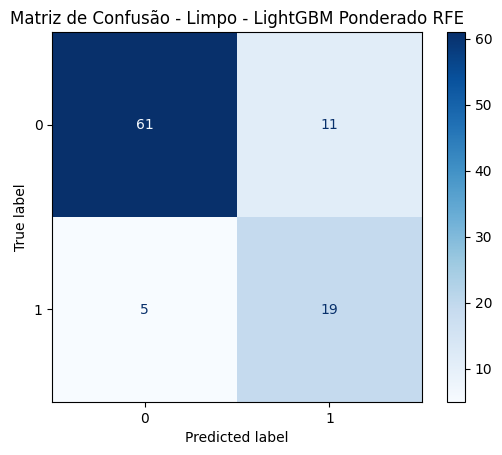


Treinando LightGBM SMOTE...
--- Resultados para: Limpo - LightGBM SMOTE ---
AUC-ROC: 0.8906
AUC-PR (Precision-Recall): 0.7519
F1-Score: 0.6545
MCC: 0.5273

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.58      0.75      0.65        24

    accuracy                           0.80        96
   macro avg       0.74      0.78      0.76        96
weighted avg       0.83      0.80      0.81        96



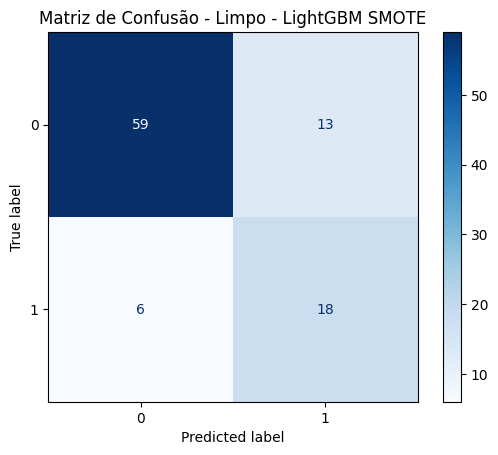


Treinando LightGBM SMOTE Ponderado...
--- Resultados para: Limpo - LightGBM SMOTE Ponderado ---
AUC-ROC: 0.8906
AUC-PR (Precision-Recall): 0.7519
F1-Score: 0.6545
MCC: 0.5273

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.58      0.75      0.65        24

    accuracy                           0.80        96
   macro avg       0.74      0.78      0.76        96
weighted avg       0.83      0.80      0.81        96



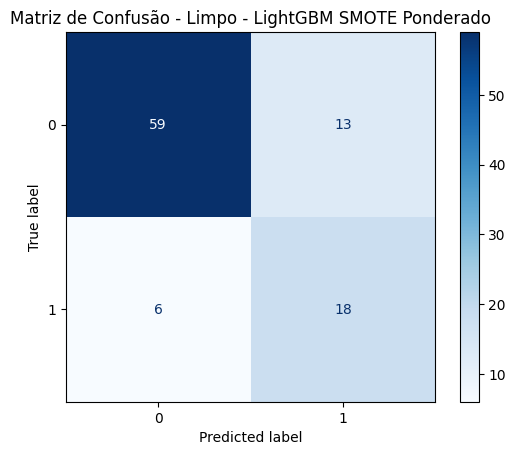


Treinando LightGBM SMOTE RFE...
--- Resultados para: Limpo - LightGBM SMOTE RFE ---
AUC-ROC: 0.8831
AUC-PR (Precision-Recall): 0.7668
F1-Score: 0.6000
MCC: 0.4601

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        72
           1       0.58      0.62      0.60        24

    accuracy                           0.79        96
   macro avg       0.72      0.74      0.73        96
weighted avg       0.80      0.79      0.79        96



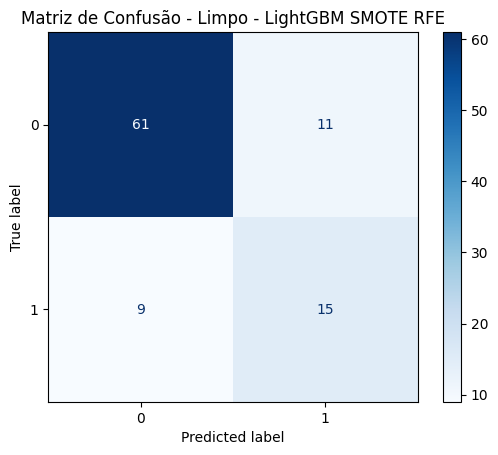


Treinando LightGBM SMOTE Ponderado RFE...
--- Resultados para: Limpo - LightGBM SMOTE Ponderado RFE ---
AUC-ROC: 0.8935
AUC-PR (Precision-Recall): 0.7545
F1-Score: 0.7273
MCC: 0.6302

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        72
           1       0.65      0.83      0.73        24

    accuracy                           0.84        96
   macro avg       0.79      0.84      0.81        96
weighted avg       0.87      0.84      0.85        96



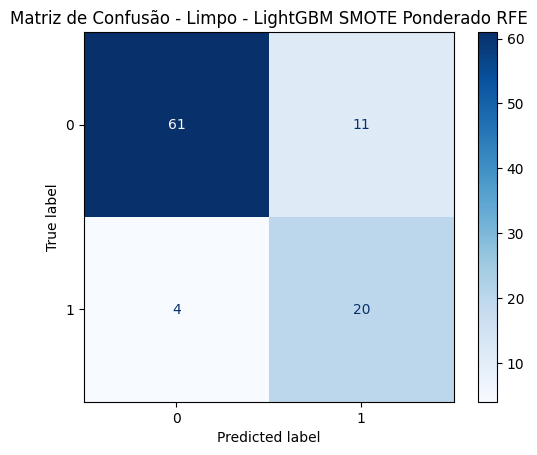


Treinando EasyEnsemble...
--- Resultados para: Limpo - EasyEnsemble ---
AUC-ROC: 0.8582
AUC-PR (Precision-Recall): 0.7356
F1-Score: 0.6567
MCC: 0.5442

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82        72
           1       0.51      0.92      0.66        24

    accuracy                           0.76        96
   macro avg       0.74      0.81      0.74        96
weighted avg       0.85      0.76      0.78        96



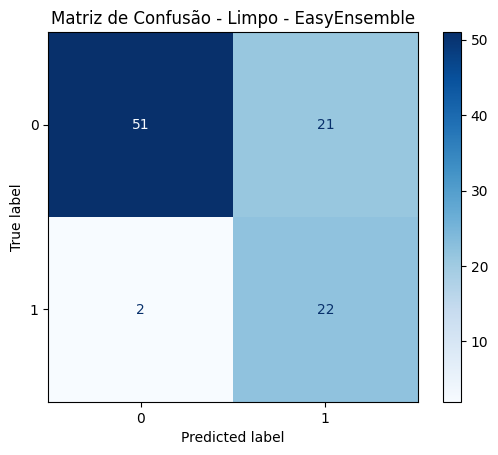


Treinando EasyEnsemble RFE...
--- Resultados para: Limpo - EasyEnsemble RFE ---
AUC-ROC: 0.8675
AUC-PR (Precision-Recall): 0.7195
F1-Score: 0.6567
MCC: 0.5442

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82        72
           1       0.51      0.92      0.66        24

    accuracy                           0.76        96
   macro avg       0.74      0.81      0.74        96
weighted avg       0.85      0.76      0.78        96



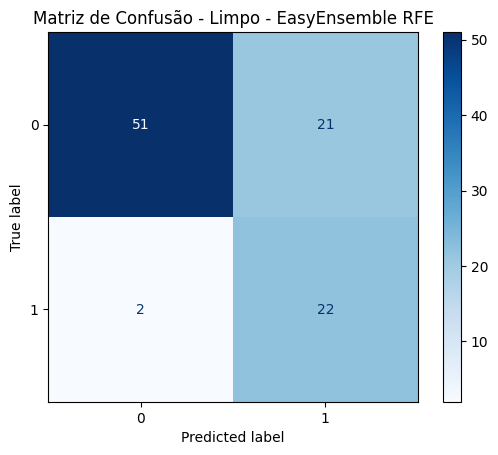


Treinando EasyEnsemble...
--- Resultados para: Limpo - EasyEnsemble ---
AUC-ROC: 0.8582
AUC-PR (Precision-Recall): 0.7356
F1-Score: 0.6567
MCC: 0.5442

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82        72
           1       0.51      0.92      0.66        24

    accuracy                           0.76        96
   macro avg       0.74      0.81      0.74        96
weighted avg       0.85      0.76      0.78        96



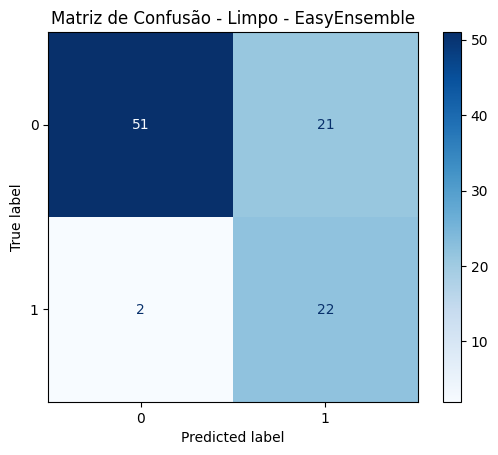


Treinando EasyEnsemble RFE...
--- Resultados para: Limpo - EasyEnsemble RFE ---
AUC-ROC: 0.8675
AUC-PR (Precision-Recall): 0.7195
F1-Score: 0.6567
MCC: 0.5442

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82        72
           1       0.51      0.92      0.66        24

    accuracy                           0.76        96
   macro avg       0.74      0.81      0.74        96
weighted avg       0.85      0.76      0.78        96



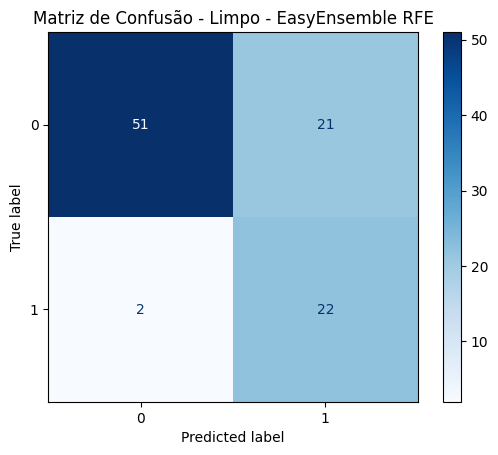


Treinando RUSBoost...
--- Resultados para: Limpo - RUSBoost ---
AUC-ROC: 0.8796
AUC-PR (Precision-Recall): 0.7811
F1-Score: 0.6557
MCC: 0.5314

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84        72
           1       0.54      0.83      0.66        24

    accuracy                           0.78        96
   macro avg       0.74      0.80      0.75        96
weighted avg       0.83      0.78      0.79        96



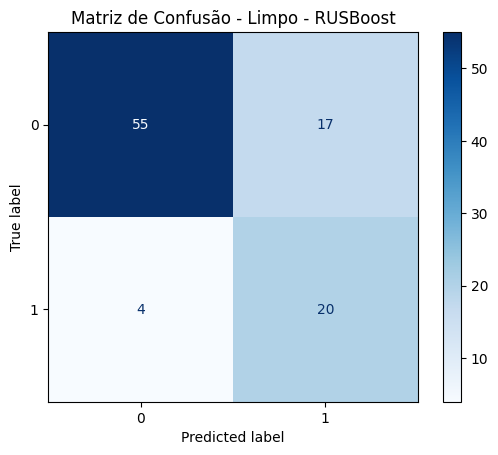


Treinando RUSBoost RFE...
--- Resultados para: Limpo - RUSBoost RFE ---
AUC-ROC: 0.8791
AUC-PR (Precision-Recall): 0.7593
F1-Score: 0.6562
MCC: 0.5367

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83        72
           1       0.53      0.88      0.66        24

    accuracy                           0.77        96
   macro avg       0.74      0.81      0.74        96
weighted avg       0.84      0.77      0.79        96



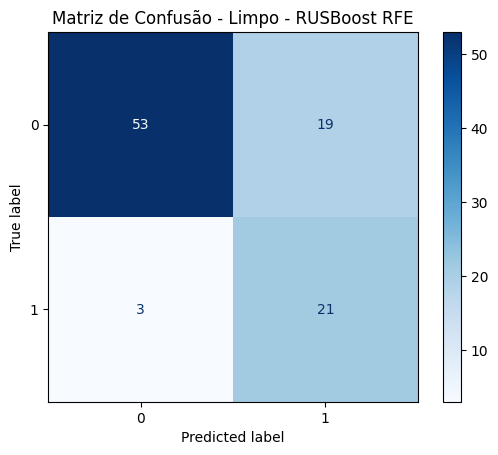


Treinando KNN...
--- Resultados para: Limpo - KNN ---
AUC-ROC: 0.5613
AUC-PR (Precision-Recall): 0.2708
F1-Score: 0.0714
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        72
           1       0.25      0.04      0.07        24

    accuracy                           0.73        96
   macro avg       0.50      0.50      0.46        96
weighted avg       0.62      0.73      0.65        96



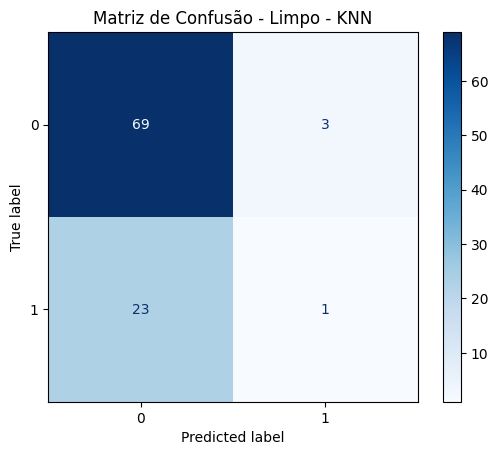


Treinando RandomForest...
--- Resultados para: Limpo - RandomForest ---
AUC-ROC: 0.8733
AUC-PR (Precision-Recall): 0.7473
F1-Score: 0.5294
MCC: 0.5119

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90        72
           1       0.90      0.38      0.53        24

    accuracy                           0.83        96
   macro avg       0.86      0.68      0.71        96
weighted avg       0.84      0.83      0.81        96



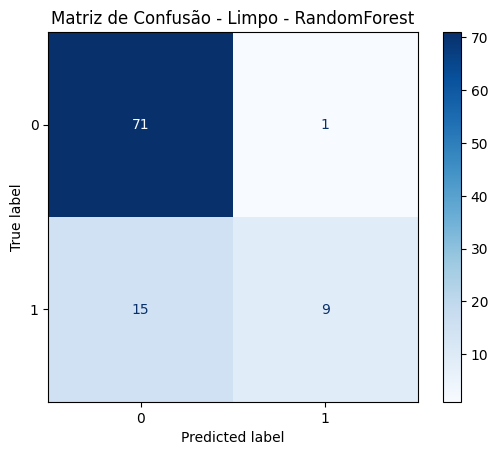


Treinando RandomForest RFE...
--- Resultados para: Limpo - RandomForest RFE ---
AUC-ROC: 0.8663
AUC-PR (Precision-Recall): 0.7496
F1-Score: 0.5789
MCC: 0.5112

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        72
           1       0.79      0.46      0.58        24

    accuracy                           0.83        96
   macro avg       0.81      0.71      0.74        96
weighted avg       0.83      0.83      0.82        96



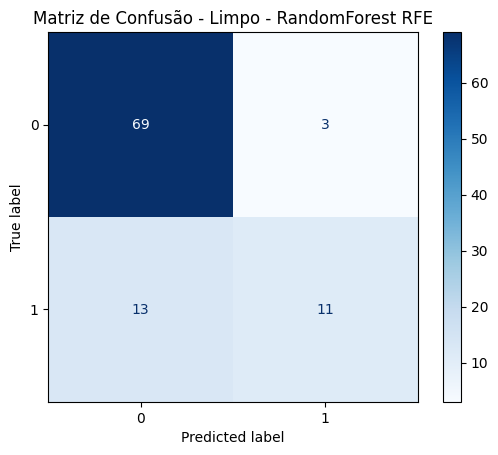


Treinando BalancedRandomForest...


/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

--- Resultados para: Limpo - BalancedRandomForest ---
AUC-ROC: 0.8368
AUC-PR (Precision-Recall): 0.6853
F1-Score: 0.5970
MCC: 0.4475

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78        72
           1       0.47      0.83      0.60        24

    accuracy                           0.72        96
   macro avg       0.69      0.76      0.69        96
weighted avg       0.81      0.72      0.74        96



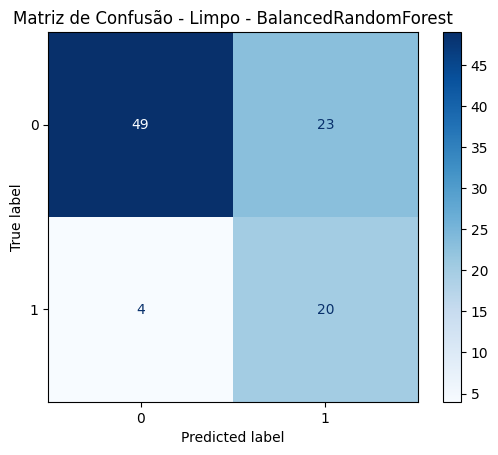


Treinando XGBoost...
[20:05:45] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Limpo - XGBoost ---
AUC-ROC: 0.8675
AUC-PR (Precision-Recall): 0.7515
F1-Score: 0.5957
MCC: 0.4650

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        72
           1       0.61      0.58      0.60        24

    accuracy                           0.80        96
   macro avg       0.74      0.73      0.73        96
weighted avg       0.80      0.80      0.80        96



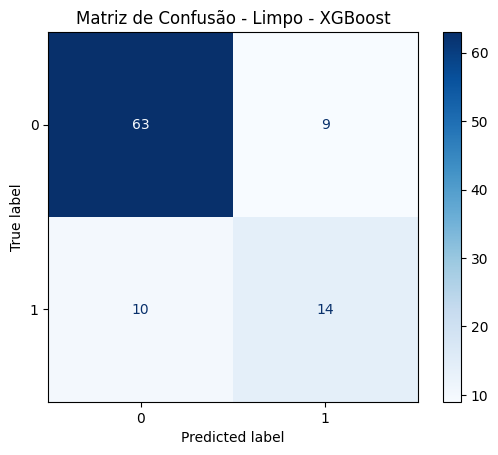


Treinando XGBoost RFE...
[20:06:20] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Limpo - XGBoost RFE ---
AUC-ROC: 0.8947
AUC-PR (Precision-Recall): 0.7854
F1-Score: 0.6538
MCC: 0.5293

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87        72
           1       0.61      0.71      0.65        24

    accuracy                           0.81        96
   macro avg       0.75      0.78      0.76        96
weighted avg       0.82      0.81      0.82        96



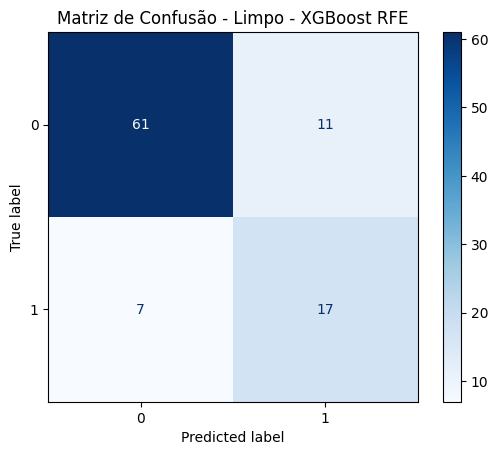


Treinando CatBoost...
--- Resultados para: Limpo - CatBoost ---
AUC-ROC: 0.8877
AUC-PR (Precision-Recall): 0.7655
F1-Score: 0.6341
MCC: 0.5514

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        72
           1       0.76      0.54      0.63        24

    accuracy                           0.84        96
   macro avg       0.81      0.74      0.77        96
weighted avg       0.84      0.84      0.83        96



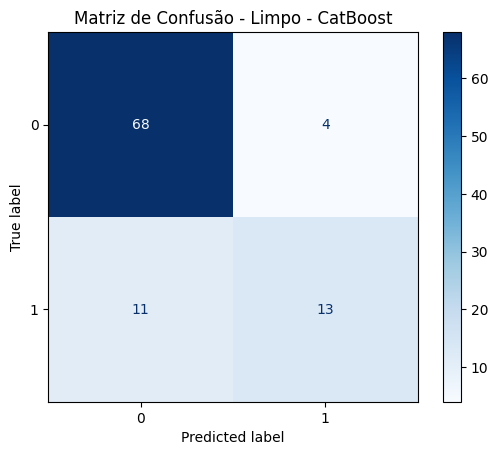


Treinando CatBoost RFE...
--- Resultados para: Limpo - CatBoost RFE ---
AUC-ROC: 0.8681
AUC-PR (Precision-Recall): 0.7200
F1-Score: 0.5263
MCC: 0.4430

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        72
           1       0.71      0.42      0.53        24

    accuracy                           0.81        96
   macro avg       0.77      0.68      0.70        96
weighted avg       0.80      0.81      0.79        96



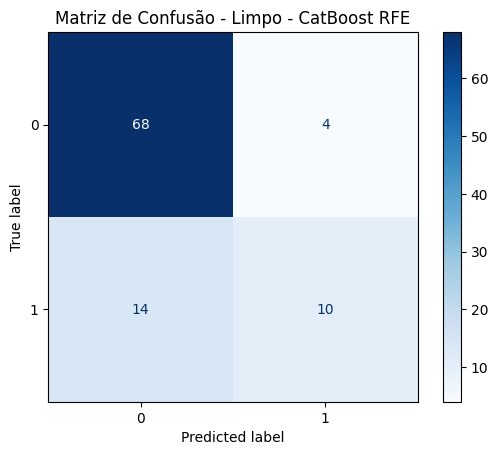


Treinando GradientBoosting...
--- Resultados para: Limpo - GradientBoosting ---
AUC-ROC: 0.8837
AUC-PR (Precision-Recall): 0.7294
F1-Score: 0.6818
MCC: 0.5923

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        72
           1       0.75      0.62      0.68        24

    accuracy                           0.85        96
   macro avg       0.82      0.78      0.79        96
weighted avg       0.85      0.85      0.85        96



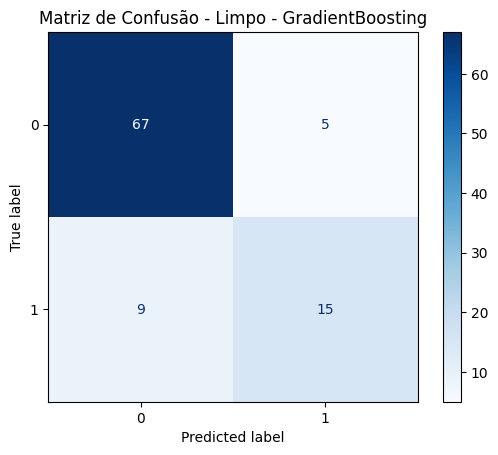


Treinando GradientBoosting RFE...
--- Resultados para: Limpo - GradientBoosting RFE ---
AUC-ROC: 0.8981
AUC-PR (Precision-Recall): 0.7369
F1-Score: 0.5909
MCC: 0.4739

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        72
           1       0.65      0.54      0.59        24

    accuracy                           0.81        96
   macro avg       0.75      0.72      0.73        96
weighted avg       0.80      0.81      0.81        96



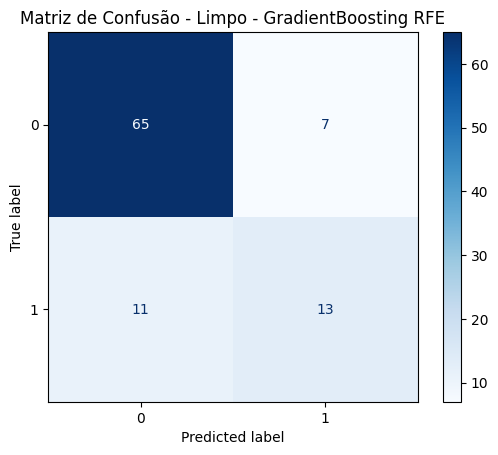

,model_name,roc_auc,pr_auc,f1,mcc
0,Limpo - LightGBM SMOTE Ponderado RFE,0.893519,0.754475,0.727273,0.630228
1,Limpo - LightGBM Ponderado RFE,0.899306,0.814625,0.703704,0.596849
2,Limpo - GradientBoosting,0.883681,0.729421,0.681818,0.592349
3,Limpo - CatBoost,0.887731,0.765519,0.634146,0.551403
4,Limpo - LightGBM Ponderado,0.901042,0.818408,0.666667,0.548424
5,Limpo - EasyEnsemble,0.858218,0.735608,0.656716,0.544227
6,Limpo - EasyEnsemble RFE,0.867477,0.719530,0.656716,0.544227
7,Limpo - EasyEnsemble,0.858218,0.735608,0.656716,0.544227
8,Limpo - EasyEnsemble RFE,0.867477,0.719530,0.656716,0.544227
9,Limpo - RUSBoost RFE,0.879051,0.759278,0.656250,0.536745


In [10]:
# Treinar e avaliar modelos nos dados limpos sem escalonamento
resultados = []
X_train_cleaned, X_val_cleaned, y_train_cleaned, y_val_cleaned = split_data(X_cleaned, y)

for descricao_dataset, model_name, model in prepara_modelos(descricao_dataset="Limpo"):
    print(f"\nTreinando {model_name}...")
    model.fit(X_train_cleaned, y_train_cleaned)
    resultado = avaliar_modelo(model, X_val_cleaned, y_val_cleaned, model_name=f"{descricao_dataset} - {model_name}")
    resultados.append(resultado)

df_temp = pd.DataFrame(resultados).sort_values('mcc', ascending=False).reset_index(drop=True)
resultados_dfs.append(df_temp)
df_temp


Treinando Regressão Logística...
--- Resultados para: Limpo Escalonado Geral - Regressão Logística ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:


/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



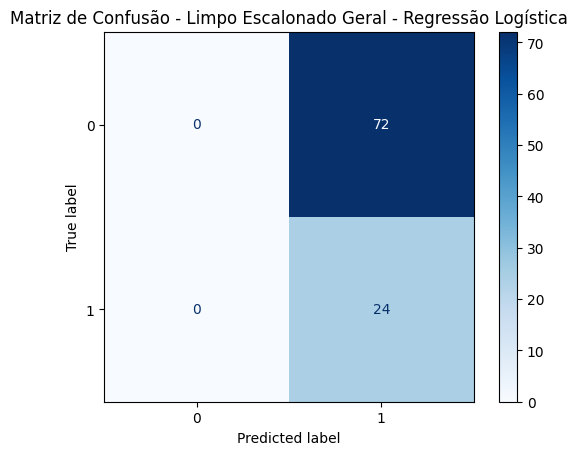


Treinando LogisticRegression Ponderado...
--- Resultados para: Limpo Escalonado Geral - LogisticRegression Ponderado ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

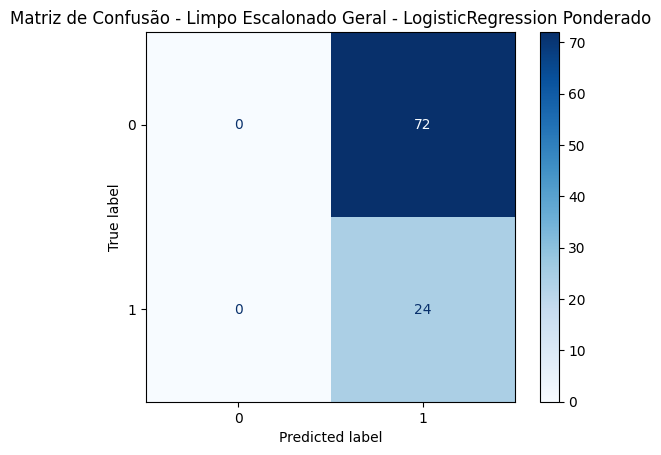


Treinando LightGBM...
--- Resultados para: Limpo Escalonado Geral - LightGBM ---
AUC-ROC: 0.8854
AUC-PR (Precision-Recall): 0.7791
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



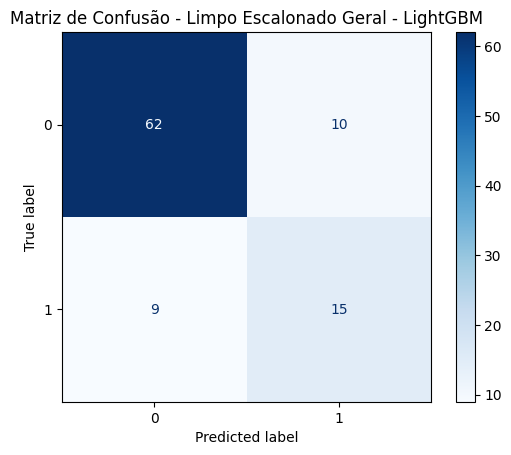


Treinando LightGBM RFE...
--- Resultados para: Limpo Escalonado Geral - LightGBM RFE ---
AUC-ROC: 0.8929
AUC-PR (Precision-Recall): 0.8051
F1-Score: 0.6522
MCC: 0.5437

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        72
           1       0.68      0.62      0.65        24

    accuracy                           0.83        96
   macro avg       0.78      0.76      0.77        96
weighted avg       0.83      0.83      0.83        96



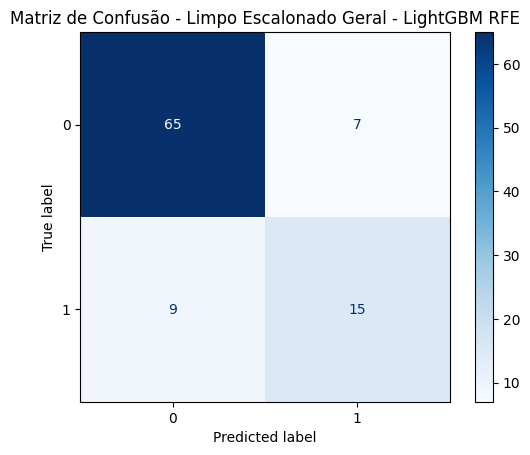


Treinando LightGBM Ponderado...
--- Resultados para: Limpo Escalonado Geral - LightGBM Ponderado ---
AUC-ROC: 0.9010
AUC-PR (Precision-Recall): 0.8184
F1-Score: 0.6667
MCC: 0.5484

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        72
           1       0.63      0.71      0.67        24

    accuracy                           0.82        96
   macro avg       0.76      0.78      0.77        96
weighted avg       0.83      0.82      0.83        96



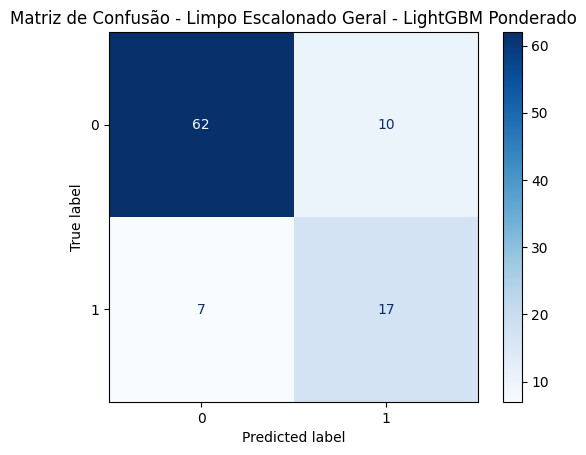


Treinando LightGBM Ponderado RFE...
--- Resultados para: Limpo Escalonado Geral - LightGBM Ponderado RFE ---
AUC-ROC: 0.8941
AUC-PR (Precision-Recall): 0.8086
F1-Score: 0.6667
MCC: 0.5449

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        72
           1       0.60      0.75      0.67        24

    accuracy                           0.81        96
   macro avg       0.75      0.79      0.77        96
weighted avg       0.83      0.81      0.82        96



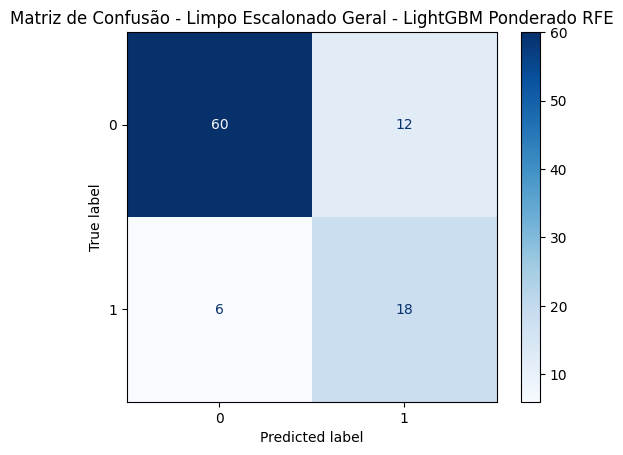


Treinando LightGBM SMOTE...
--- Resultados para: Limpo Escalonado Geral - LightGBM SMOTE ---
AUC-ROC: 0.8617
AUC-PR (Precision-Recall): 0.7653
F1-Score: 0.5882
MCC: 0.4414

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        72
           1       0.56      0.62      0.59        24

    accuracy                           0.78        96
   macro avg       0.71      0.73      0.72        96
weighted avg       0.79      0.78      0.79        96



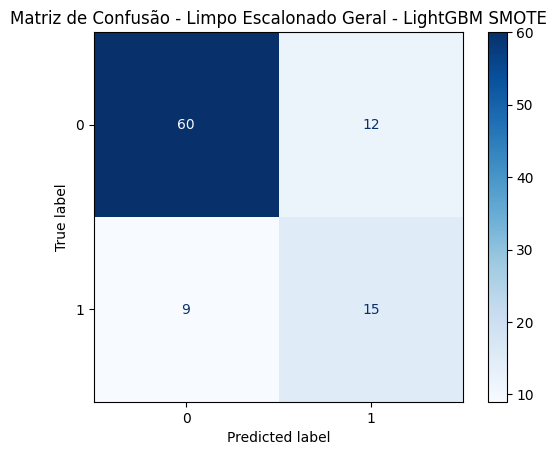


Treinando LightGBM SMOTE Ponderado...
--- Resultados para: Limpo Escalonado Geral - LightGBM SMOTE Ponderado ---
AUC-ROC: 0.8617
AUC-PR (Precision-Recall): 0.7653
F1-Score: 0.5882
MCC: 0.4414

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        72
           1       0.56      0.62      0.59        24

    accuracy                           0.78        96
   macro avg       0.71      0.73      0.72        96
weighted avg       0.79      0.78      0.79        96



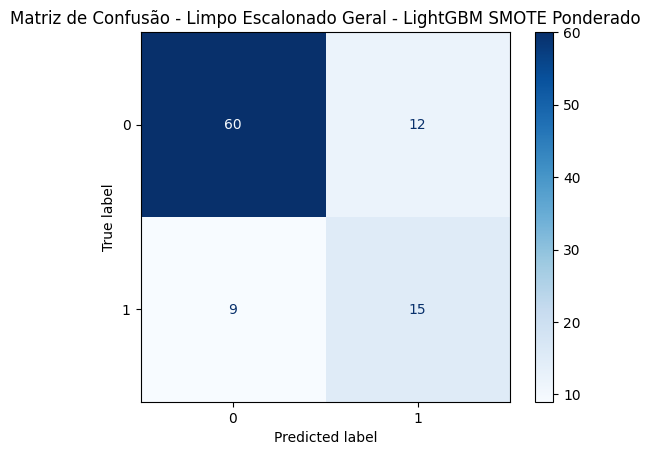


Treinando LightGBM SMOTE RFE...
--- Resultados para: Limpo Escalonado Geral - LightGBM SMOTE RFE ---
AUC-ROC: 0.8929
AUC-PR (Precision-Recall): 0.8051
F1-Score: 0.6522
MCC: 0.5437

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        72
           1       0.68      0.62      0.65        24

    accuracy                           0.83        96
   macro avg       0.78      0.76      0.77        96
weighted avg       0.83      0.83      0.83        96



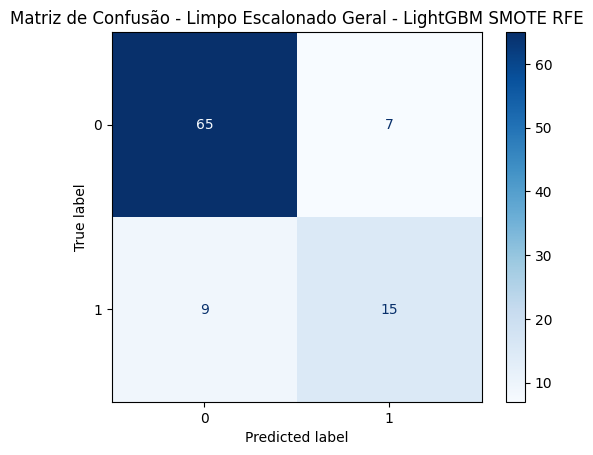


Treinando LightGBM SMOTE Ponderado RFE...
--- Resultados para: Limpo Escalonado Geral - LightGBM SMOTE Ponderado RFE ---
AUC-ROC: 0.8600
AUC-PR (Precision-Recall): 0.7582
F1-Score: 0.6000
MCC: 0.4601

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        72
           1       0.58      0.62      0.60        24

    accuracy                           0.79        96
   macro avg       0.72      0.74      0.73        96
weighted avg       0.80      0.79      0.79        96



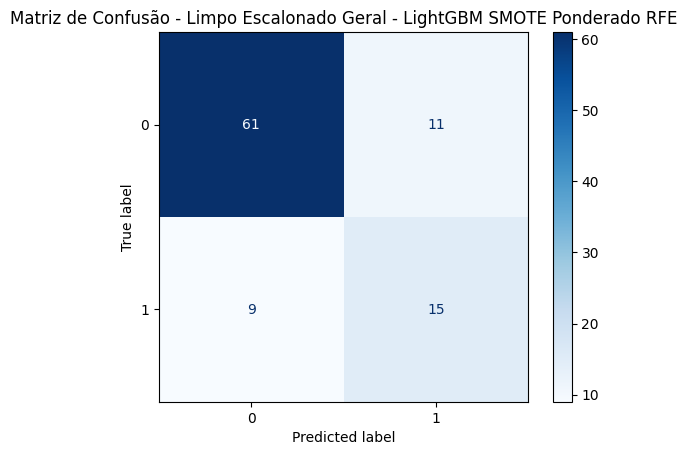


Treinando EasyEnsemble...
--- Resultados para: Limpo Escalonado Geral - EasyEnsemble ---
AUC-ROC: 0.8628
AUC-PR (Precision-Recall): 0.7098
F1-Score: 0.6250
MCC: 0.4880

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        72
           1       0.50      0.83      0.62        24

    accuracy                           0.75        96
   macro avg       0.71      0.78      0.72        96
weighted avg       0.82      0.75      0.77        96



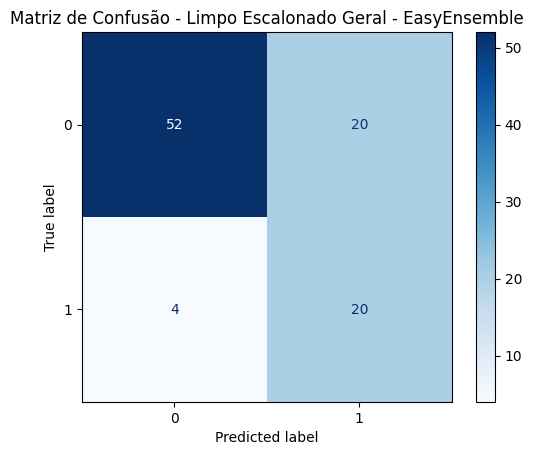


Treinando EasyEnsemble RFE...
--- Resultados para: Limpo Escalonado Geral - EasyEnsemble RFE ---
AUC-ROC: 0.8906
AUC-PR (Precision-Recall): 0.7227
F1-Score: 0.6761
MCC: 0.5895

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        72
           1       0.51      1.00      0.68        24

    accuracy                           0.76        96
   macro avg       0.76      0.84      0.74        96
weighted avg       0.88      0.76      0.78        96



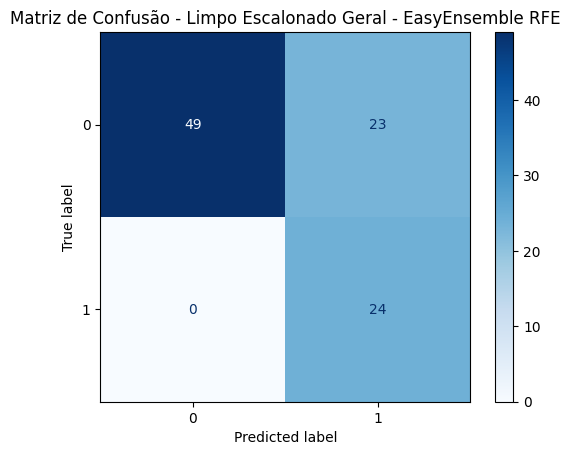


Treinando EasyEnsemble...
--- Resultados para: Limpo Escalonado Geral - EasyEnsemble ---
AUC-ROC: 0.8628
AUC-PR (Precision-Recall): 0.7098
F1-Score: 0.6250
MCC: 0.4880

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        72
           1       0.50      0.83      0.62        24

    accuracy                           0.75        96
   macro avg       0.71      0.78      0.72        96
weighted avg       0.82      0.75      0.77        96



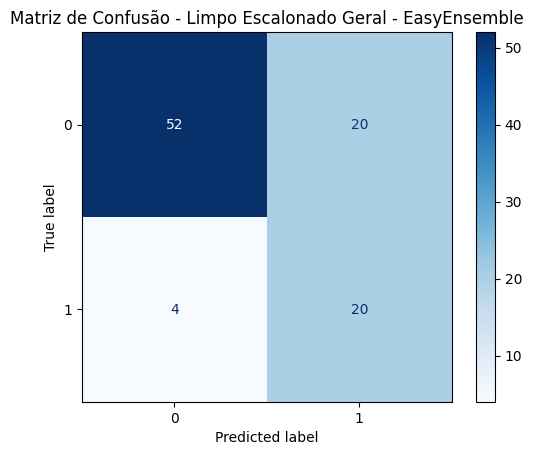


Treinando EasyEnsemble RFE...
--- Resultados para: Limpo Escalonado Geral - EasyEnsemble RFE ---
AUC-ROC: 0.8906
AUC-PR (Precision-Recall): 0.7227
F1-Score: 0.6761
MCC: 0.5895

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        72
           1       0.51      1.00      0.68        24

    accuracy                           0.76        96
   macro avg       0.76      0.84      0.74        96
weighted avg       0.88      0.76      0.78        96



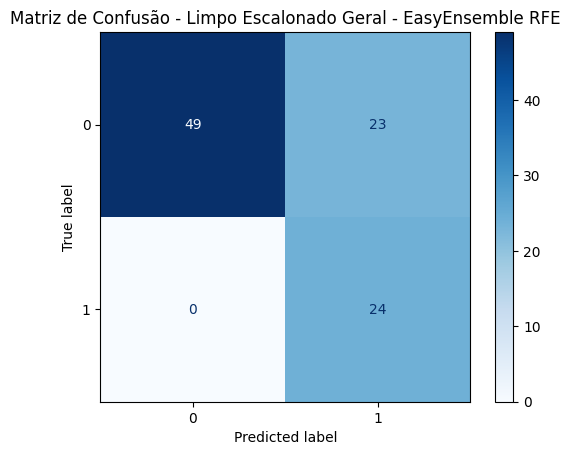


Treinando RUSBoost...
--- Resultados para: Limpo Escalonado Geral - RUSBoost ---
AUC-ROC: 0.8657
AUC-PR (Precision-Recall): 0.7105
F1-Score: 0.6197
MCC: 0.4933

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78        72
           1       0.47      0.92      0.62        24

    accuracy                           0.72        96
   macro avg       0.71      0.78      0.70        96
weighted avg       0.84      0.72      0.74        96



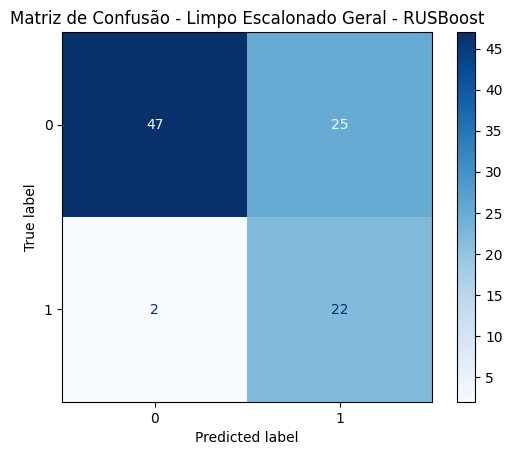


Treinando RUSBoost RFE...
--- Resultados para: Limpo Escalonado Geral - RUSBoost RFE ---
AUC-ROC: 0.8576
AUC-PR (Precision-Recall): 0.7126
F1-Score: 0.6462
MCC: 0.5228

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82        72
           1       0.51      0.88      0.65        24

    accuracy                           0.76        96
   macro avg       0.73      0.80      0.73        96
weighted avg       0.84      0.76      0.78        96



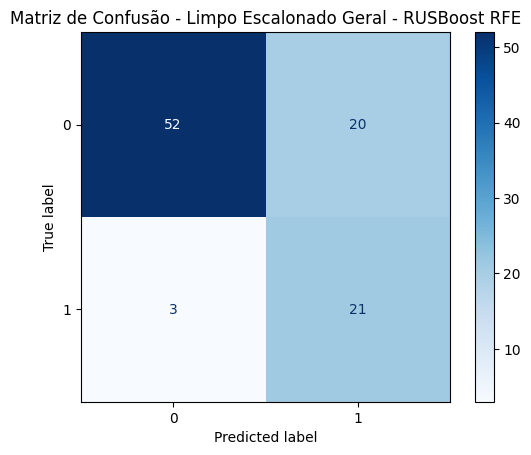


Treinando KNN...
--- Resultados para: Limpo Escalonado Geral - KNN ---
AUC-ROC: 0.7289
AUC-PR (Precision-Recall): 0.5200
F1-Score: 0.3529
MCC: 0.2756

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        72
           1       0.60      0.25      0.35        24

    accuracy                           0.77        96
   macro avg       0.70      0.60      0.61        96
weighted avg       0.74      0.77      0.73        96



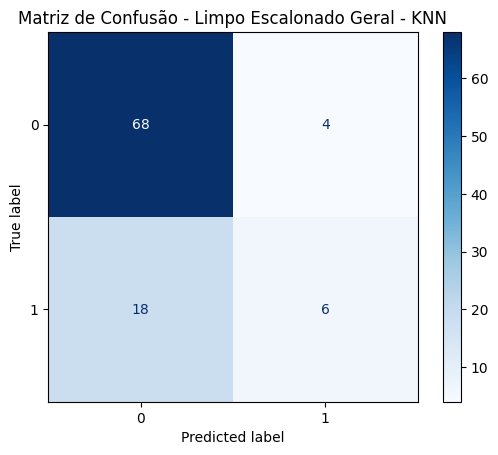


Treinando RandomForest...
--- Resultados para: Limpo Escalonado Geral - RandomForest ---
AUC-ROC: 0.8692
AUC-PR (Precision-Recall): 0.7437
F1-Score: 0.5143
MCC: 0.4720

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        72
           1       0.82      0.38      0.51        24

    accuracy                           0.82        96
   macro avg       0.82      0.67      0.70        96
weighted avg       0.82      0.82      0.80        96



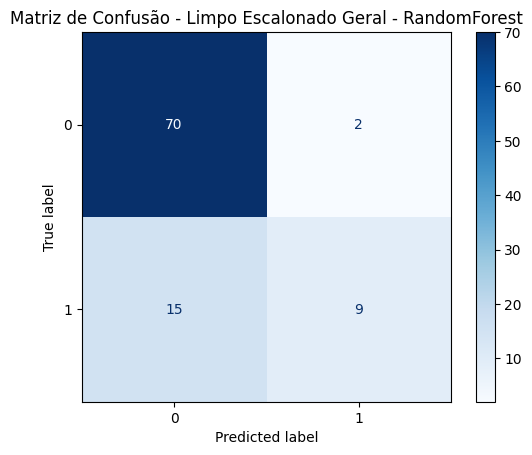


Treinando RandomForest RFE...
--- Resultados para: Limpo Escalonado Geral - RandomForest RFE ---
AUC-ROC: 0.8530
AUC-PR (Precision-Recall): 0.7115
F1-Score: 0.5405
MCC: 0.4746

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.77      0.42      0.54        24

    accuracy                           0.82        96
   macro avg       0.80      0.69      0.72        96
weighted avg       0.82      0.82      0.80        96



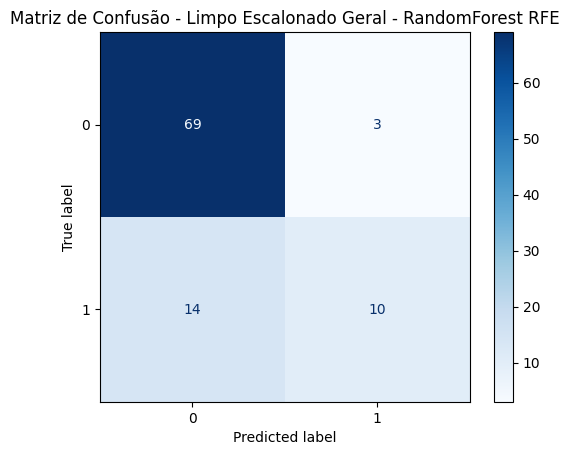


Treinando BalancedRandomForest...


/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

--- Resultados para: Limpo Escalonado Geral - BalancedRandomForest ---
AUC-ROC: 0.8429
AUC-PR (Precision-Recall): 0.6828
F1-Score: 0.5846
MCC: 0.4255

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79        72
           1       0.46      0.79      0.58        24

    accuracy                           0.72        96
   macro avg       0.69      0.74      0.69        96
weighted avg       0.80      0.72      0.74        96



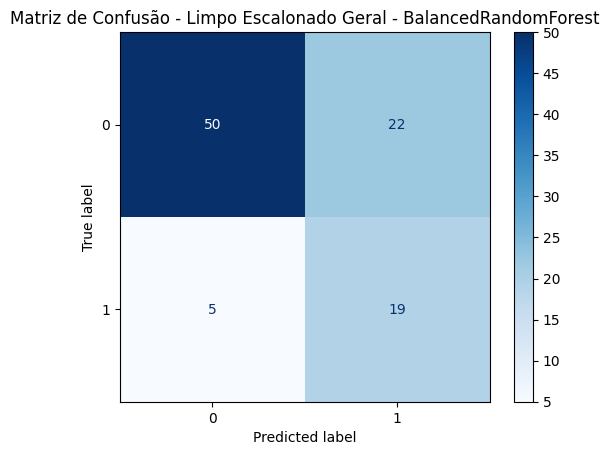


Treinando XGBoost...
[20:14:45] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Limpo Escalonado Geral - XGBoost ---
AUC-ROC: 0.8657
AUC-PR (Precision-Recall): 0.7500
F1-Score: 0.5957
MCC: 0.4650

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        72
           1       0.61      0.58      0.60        24

    accuracy                           0.80        96
   macro avg       0.74      0.73      0.73        96
weighted avg       0.80      0.80      0.80        96



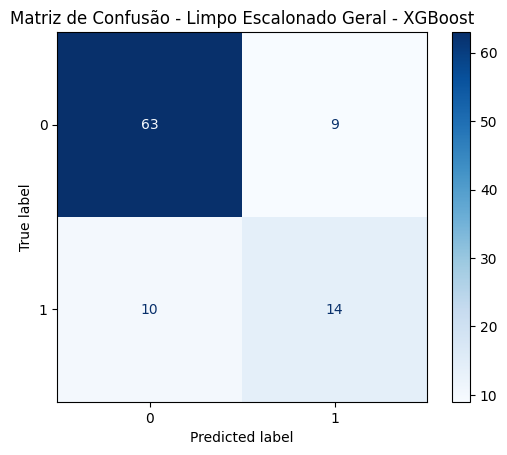


Treinando XGBoost RFE...
[20:15:28] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Limpo Escalonado Geral - XGBoost RFE ---
AUC-ROC: 0.8652
AUC-PR (Precision-Recall): 0.7548
F1-Score: 0.6531
MCC: 0.5344

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        72
           1       0.64      0.67      0.65        24

    accuracy                           0.82        96
   macro avg       0.76      0.77      0.77        96
weighted avg       0.83      0.82      0.82        96



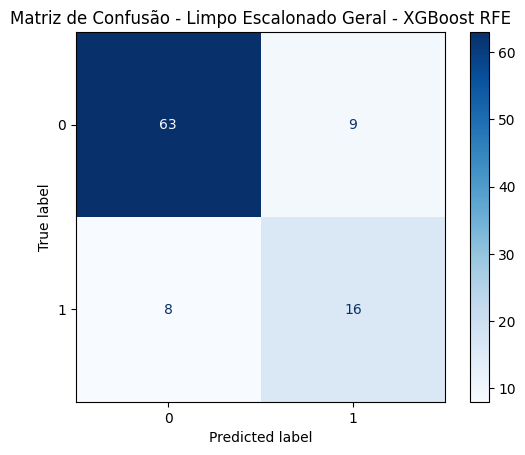


Treinando CatBoost...
--- Resultados para: Limpo Escalonado Geral - CatBoost ---
AUC-ROC: 0.8819
AUC-PR (Precision-Recall): 0.7626
F1-Score: 0.6000
MCC: 0.5164

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        72
           1       0.75      0.50      0.60        24

    accuracy                           0.83        96
   macro avg       0.80      0.72      0.75        96
weighted avg       0.82      0.83      0.82        96



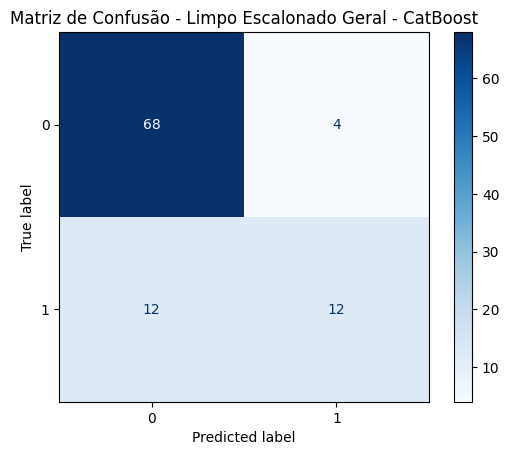


Treinando CatBoost RFE...
--- Resultados para: Limpo Escalonado Geral - CatBoost RFE ---
AUC-ROC: 0.8843
AUC-PR (Precision-Recall): 0.7523
F1-Score: 0.5405
MCC: 0.4746

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.77      0.42      0.54        24

    accuracy                           0.82        96
   macro avg       0.80      0.69      0.72        96
weighted avg       0.82      0.82      0.80        96



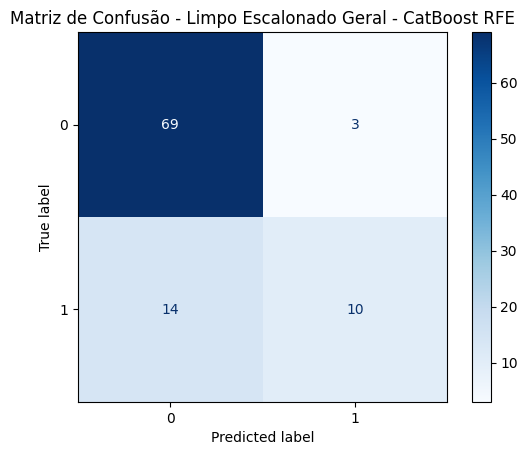


Treinando GradientBoosting...
--- Resultados para: Limpo Escalonado Geral - GradientBoosting ---
AUC-ROC: 0.8883
AUC-PR (Precision-Recall): 0.7441
F1-Score: 0.7556
MCC: 0.6837

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        72
           1       0.81      0.71      0.76        24

    accuracy                           0.89        96
   macro avg       0.86      0.83      0.84        96
weighted avg       0.88      0.89      0.88        96



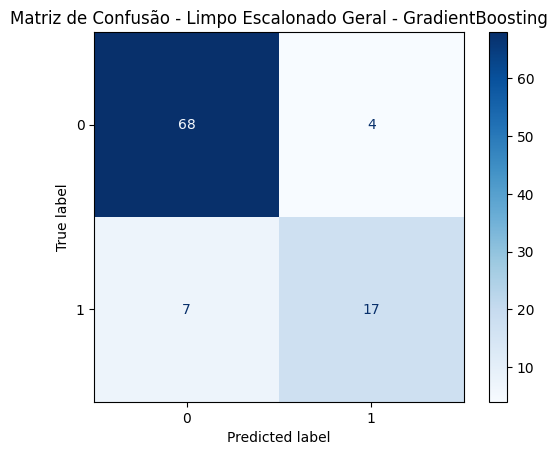


Treinando GradientBoosting RFE...
--- Resultados para: Limpo Escalonado Geral - GradientBoosting RFE ---
AUC-ROC: 0.9051
AUC-PR (Precision-Recall): 0.7448
F1-Score: 0.6341
MCC: 0.5514

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        72
           1       0.76      0.54      0.63        24

    accuracy                           0.84        96
   macro avg       0.81      0.74      0.77        96
weighted avg       0.84      0.84      0.83        96



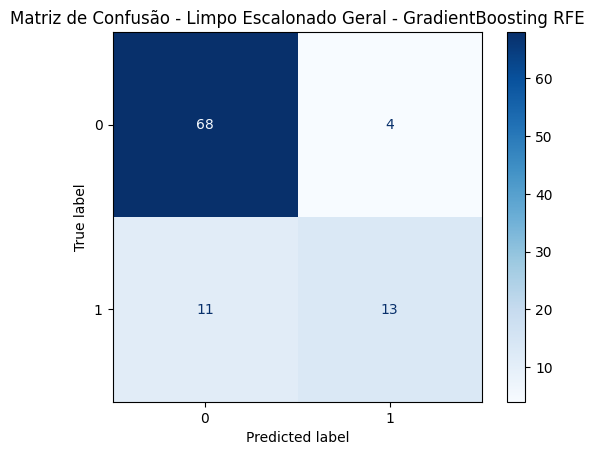

,model_name,roc_auc,pr_auc,f1,mcc
0,Limpo Escalonado Geral - GradientBoosting,0.888310,0.744104,0.755556,0.683749
1,Limpo Escalonado Geral - EasyEnsemble RFE,0.890625,0.722681,0.676056,0.589506
2,Limpo Escalonado Geral - EasyEnsemble RFE,0.890625,0.722681,0.676056,0.589506
3,Limpo Escalonado Geral - GradientBoosting RFE,0.905093,0.744762,0.634146,0.551403
4,Limpo Escalonado Geral - LightGBM Ponderado,0.901042,0.818408,0.666667,0.548424
5,Limpo Escalonado Geral - LightGBM Ponderado RFE,0.894097,0.808624,0.666667,0.544949
6,Limpo Escalonado Geral - LightGBM RFE,0.892940,0.805084,0.652174,0.543746
7,Limpo Escalonado Geral - LightGBM SMOTE RFE,0.892940,0.805084,0.652174,0.543746
8,Limpo Escalonado Geral - XGBoost RFE,0.865162,0.754797,0.653061,0.534447
9,Limpo Escalonado Geral - RUSBoost RFE,0.857639,0.712554,0.646154,0.522799


In [11]:
# Treinar e avaliar modelos nos dados limpos com escalonamento em todas as features
resultados = []
X_train_cleaned, X_val_cleaned, y_train_cleaned, y_val_cleaned = split_data(X_cleaned, y)

#numeric_cols, categorical_cols = get_numeric_categoric_features(X_train_cleaned, X_train_cleaned)
preprocessor = ColumnTransformer([
    ('num_normal', StandardScaler(), X_train_cleaned.columns.to_list()),
    #('num_skewed', PowerTransformer(method='yeo-johnson'), skewed_features),
    #('cat_nominal', OneHotEncoder(drop='first'), nominal_features),
    #('cat_ordinal', OrdinalEncoder(), ordinal_features)
], remainder='passthrough') # Mantém as colunas não especificadas inalteradas

for descricao_dataset, model_name, model in prepara_modelos(descricao_dataset="Limpo Escalonado Geral", preprocessor=preprocessor):
    print(f"\nTreinando {model_name}...")
    model.fit(X_train_cleaned, y_train_cleaned)
    resultado = avaliar_modelo(model, X_val_cleaned, y_val_cleaned, model_name=f"{descricao_dataset} - {model_name}")
    resultados.append(resultado)

df_temp = pd.DataFrame(resultados).sort_values('mcc', ascending=False).reset_index(drop=True)
resultados_dfs.append(df_temp)
df_temp


Treinando Regressão Logística...
--- Resultados para: Limpo Escalonado Numericas - Regressão Logística ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

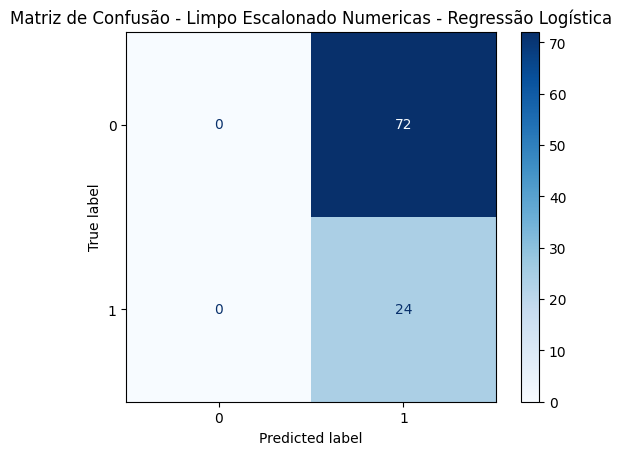


Treinando LogisticRegression Ponderado...
--- Resultados para: Limpo Escalonado Numericas - LogisticRegression Ponderado ---
AUC-ROC: 0.5081
AUC-PR (Precision-Recall): 0.3060
F1-Score: 0.4000
MCC: 0.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.12      0.50      0.20        96
weighted avg       0.06      0.25      0.10        96



/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

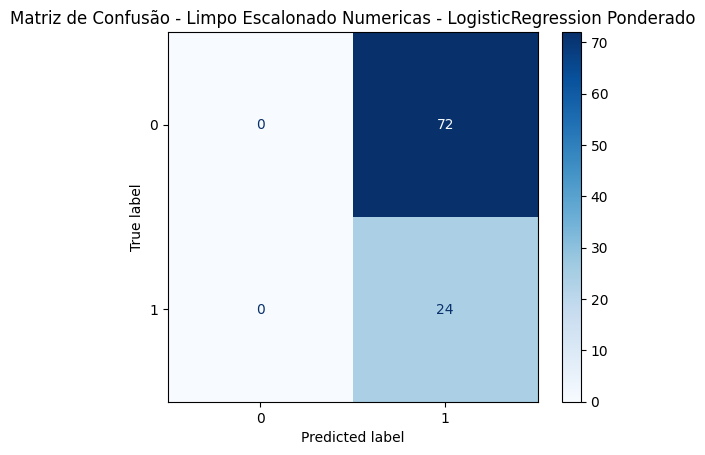


Treinando LightGBM...
--- Resultados para: Limpo Escalonado Numericas - LightGBM ---
AUC-ROC: 0.8854
AUC-PR (Precision-Recall): 0.7791
F1-Score: 0.6122
MCC: 0.4796

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.60      0.62      0.61        24

    accuracy                           0.80        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.80      0.80      0.80        96



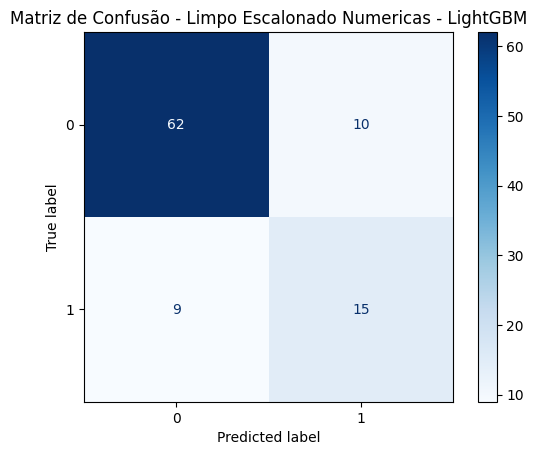


Treinando LightGBM RFE...
--- Resultados para: Limpo Escalonado Numericas - LightGBM RFE ---
AUC-ROC: 0.9005
AUC-PR (Precision-Recall): 0.8052
F1-Score: 0.6809
MCC: 0.5777

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.70      0.67      0.68        24

    accuracy                           0.84        96
   macro avg       0.79      0.78      0.79        96
weighted avg       0.84      0.84      0.84        96



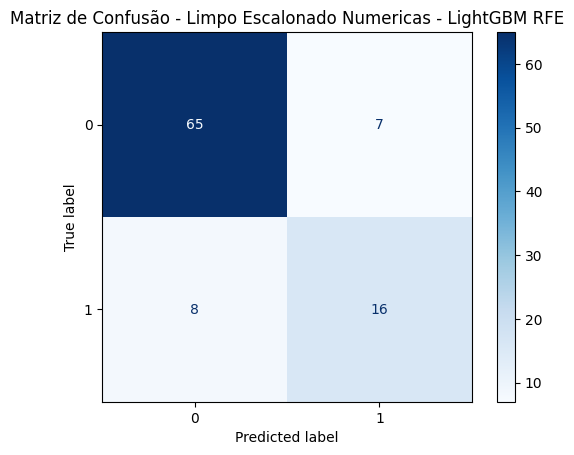


Treinando LightGBM Ponderado...
--- Resultados para: Limpo Escalonado Numericas - LightGBM Ponderado ---
AUC-ROC: 0.9010
AUC-PR (Precision-Recall): 0.8184
F1-Score: 0.6667
MCC: 0.5484

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        72
           1       0.63      0.71      0.67        24

    accuracy                           0.82        96
   macro avg       0.76      0.78      0.77        96
weighted avg       0.83      0.82      0.83        96



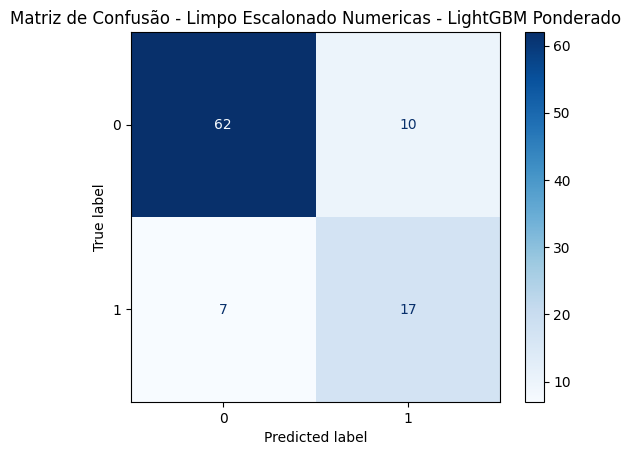


Treinando LightGBM Ponderado RFE...
--- Resultados para: Limpo Escalonado Numericas - LightGBM Ponderado RFE ---
AUC-ROC: 0.9028
AUC-PR (Precision-Recall): 0.8097
F1-Score: 0.6923
MCC: 0.5822

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        72
           1       0.64      0.75      0.69        24

    accuracy                           0.83        96
   macro avg       0.78      0.81      0.79        96
weighted avg       0.84      0.83      0.84        96



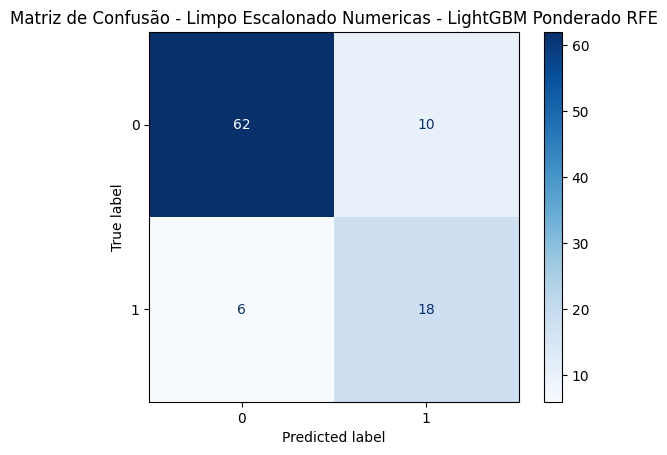


Treinando LightGBM SMOTE...
--- Resultados para: Limpo Escalonado Numericas - LightGBM SMOTE ---
AUC-ROC: 0.8698
AUC-PR (Precision-Recall): 0.7597
F1-Score: 0.6545
MCC: 0.5273

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.58      0.75      0.65        24

    accuracy                           0.80        96
   macro avg       0.74      0.78      0.76        96
weighted avg       0.83      0.80      0.81        96



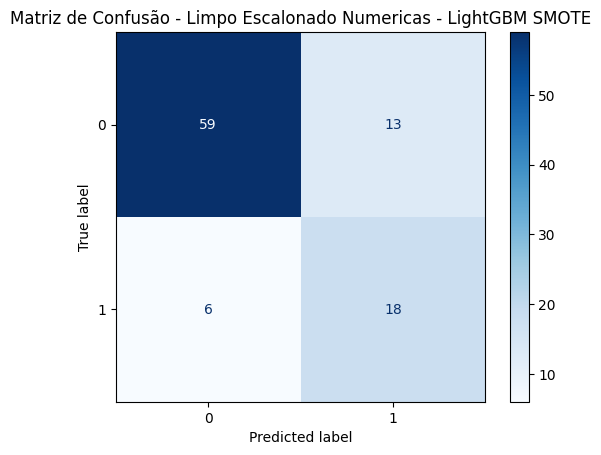


Treinando LightGBM SMOTE Ponderado...
--- Resultados para: Limpo Escalonado Numericas - LightGBM SMOTE Ponderado ---
AUC-ROC: 0.8698
AUC-PR (Precision-Recall): 0.7597
F1-Score: 0.6545
MCC: 0.5273

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.58      0.75      0.65        24

    accuracy                           0.80        96
   macro avg       0.74      0.78      0.76        96
weighted avg       0.83      0.80      0.81        96



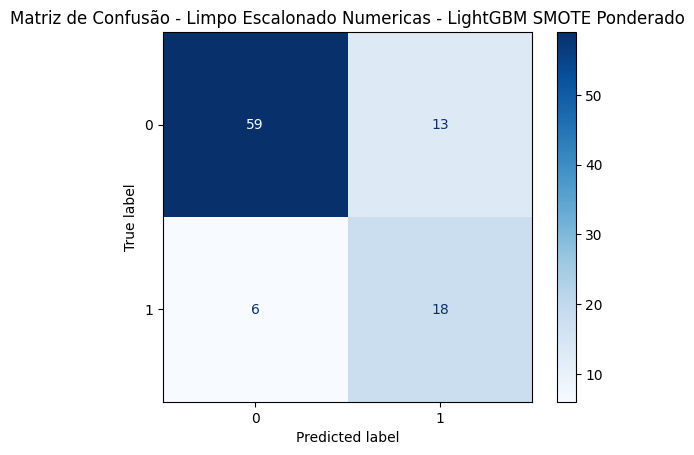


Treinando LightGBM SMOTE RFE...
--- Resultados para: Limpo Escalonado Numericas - LightGBM SMOTE RFE ---
AUC-ROC: 0.9005
AUC-PR (Precision-Recall): 0.8052
F1-Score: 0.6809
MCC: 0.5777

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.70      0.67      0.68        24

    accuracy                           0.84        96
   macro avg       0.79      0.78      0.79        96
weighted avg       0.84      0.84      0.84        96



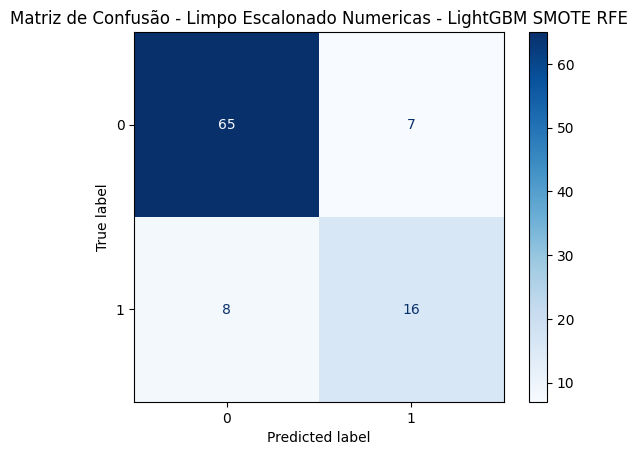


Treinando LightGBM SMOTE Ponderado RFE...
--- Resultados para: Limpo Escalonado Numericas - LightGBM SMOTE Ponderado RFE ---
AUC-ROC: 0.8744
AUC-PR (Precision-Recall): 0.7669
F1-Score: 0.6923
MCC: 0.5822

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        72
           1       0.64      0.75      0.69        24

    accuracy                           0.83        96
   macro avg       0.78      0.81      0.79        96
weighted avg       0.84      0.83      0.84        96



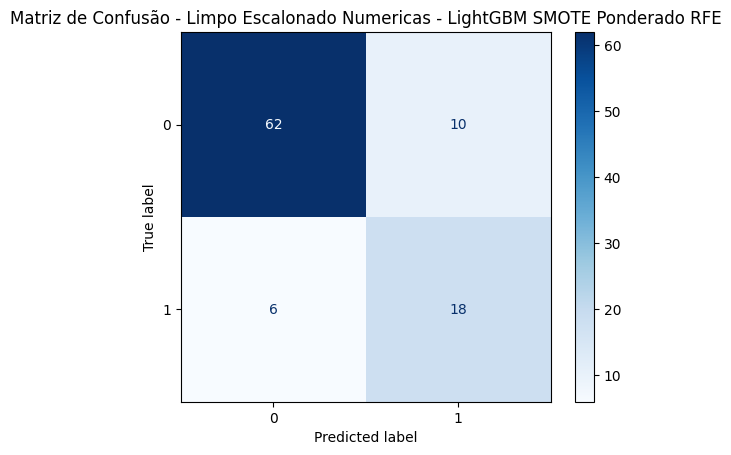


Treinando EasyEnsemble...
--- Resultados para: Limpo Escalonado Numericas - EasyEnsemble ---
AUC-ROC: 0.8738
AUC-PR (Precision-Recall): 0.7400
F1-Score: 0.6154
MCC: 0.4742

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80        72
           1       0.49      0.83      0.62        24

    accuracy                           0.74        96
   macro avg       0.71      0.77      0.71        96
weighted avg       0.82      0.74      0.76        96



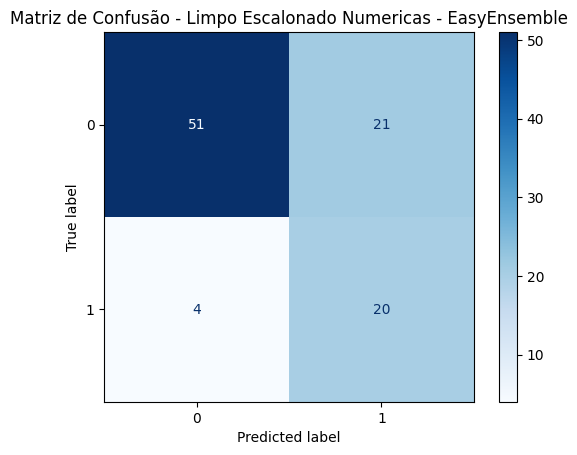


Treinando EasyEnsemble RFE...
--- Resultados para: Limpo Escalonado Numericas - EasyEnsemble RFE ---
AUC-ROC: 0.9045
AUC-PR (Precision-Recall): 0.7644
F1-Score: 0.6462
MCC: 0.5228

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82        72
           1       0.51      0.88      0.65        24

    accuracy                           0.76        96
   macro avg       0.73      0.80      0.73        96
weighted avg       0.84      0.76      0.78        96



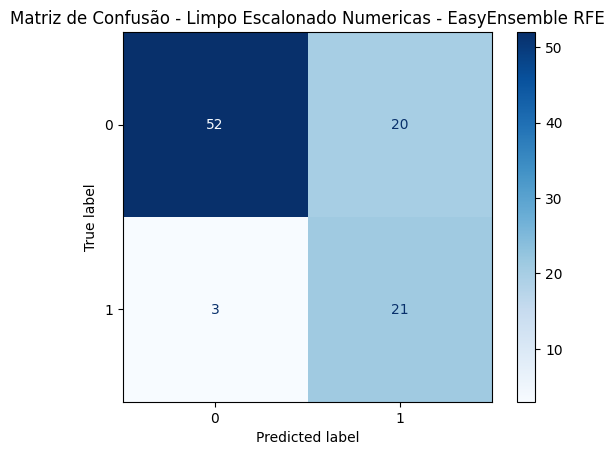


Treinando EasyEnsemble...
--- Resultados para: Limpo Escalonado Numericas - EasyEnsemble ---
AUC-ROC: 0.8738
AUC-PR (Precision-Recall): 0.7400
F1-Score: 0.6154
MCC: 0.4742

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80        72
           1       0.49      0.83      0.62        24

    accuracy                           0.74        96
   macro avg       0.71      0.77      0.71        96
weighted avg       0.82      0.74      0.76        96



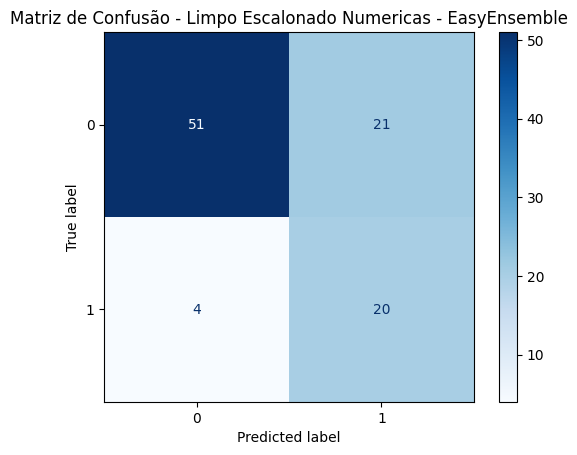


Treinando EasyEnsemble RFE...
--- Resultados para: Limpo Escalonado Numericas - EasyEnsemble RFE ---
AUC-ROC: 0.9045
AUC-PR (Precision-Recall): 0.7644
F1-Score: 0.6462
MCC: 0.5228

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82        72
           1       0.51      0.88      0.65        24

    accuracy                           0.76        96
   macro avg       0.73      0.80      0.73        96
weighted avg       0.84      0.76      0.78        96



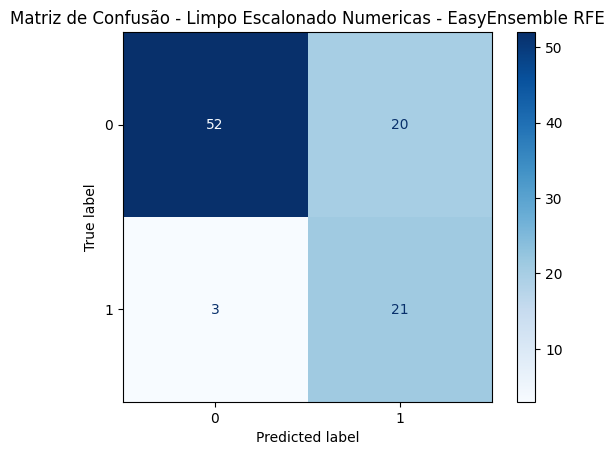


Treinando RUSBoost...
--- Resultados para: Limpo Escalonado Numericas - RUSBoost ---
AUC-ROC: 0.8744
AUC-PR (Precision-Recall): 0.7545
F1-Score: 0.6667
MCC: 0.5577

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.72      0.83        72
           1       0.52      0.92      0.67        24

    accuracy                           0.77        96
   macro avg       0.74      0.82      0.75        96
weighted avg       0.85      0.77      0.79        96



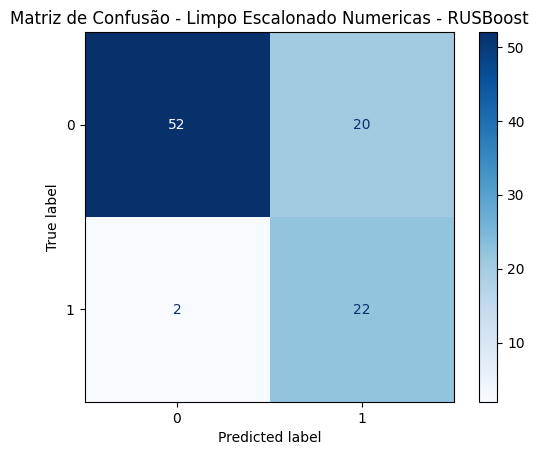


Treinando RUSBoost RFE...
--- Resultados para: Limpo Escalonado Numericas - RUSBoost RFE ---
AUC-ROC: 0.8652
AUC-PR (Precision-Recall): 0.7407
F1-Score: 0.6377
MCC: 0.5182

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80        72
           1       0.49      0.92      0.64        24

    accuracy                           0.74        96
   macro avg       0.72      0.80      0.72        96
weighted avg       0.84      0.74      0.76        96



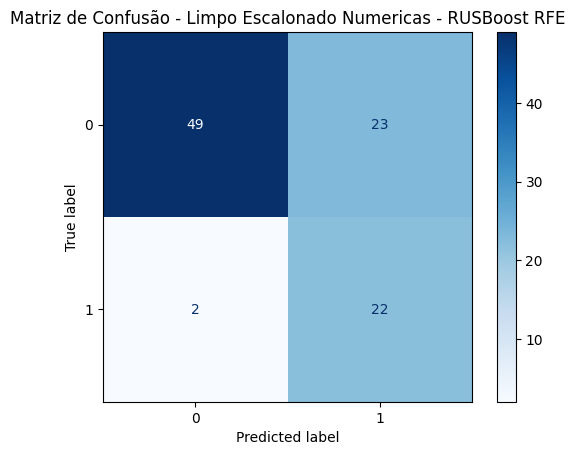


Treinando KNN...
--- Resultados para: Limpo Escalonado Numericas - KNN ---
AUC-ROC: 0.7622
AUC-PR (Precision-Recall): 0.5778
F1-Score: 0.5500
MCC: 0.4518

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        72
           1       0.69      0.46      0.55        24

    accuracy                           0.81        96
   macro avg       0.76      0.69      0.72        96
weighted avg       0.80      0.81      0.80        96



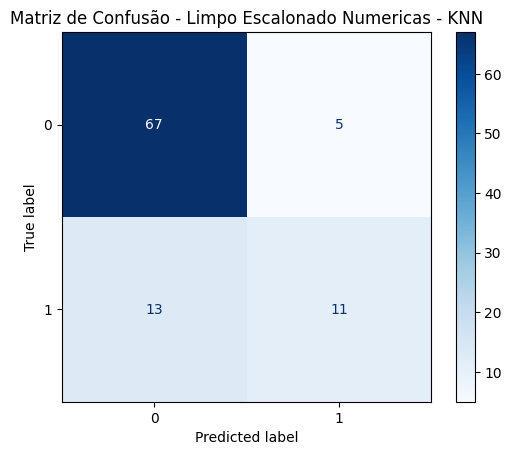


Treinando RandomForest...
--- Resultados para: Limpo Escalonado Numericas - RandomForest ---
AUC-ROC: 0.8840
AUC-PR (Precision-Recall): 0.7566
F1-Score: 0.5405
MCC: 0.4746

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.77      0.42      0.54        24

    accuracy                           0.82        96
   macro avg       0.80      0.69      0.72        96
weighted avg       0.82      0.82      0.80        96



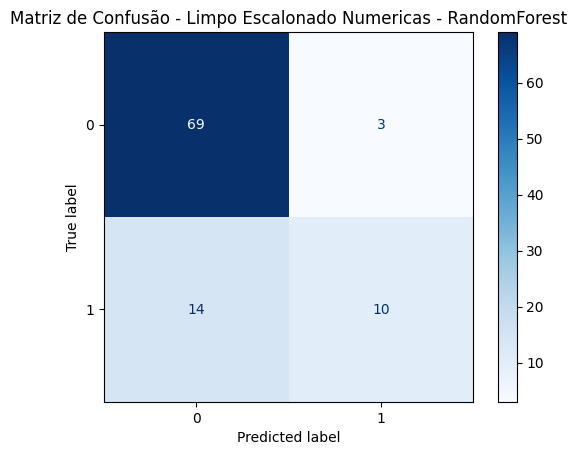


Treinando RandomForest RFE...
--- Resultados para: Limpo Escalonado Numericas - RandomForest RFE ---
AUC-ROC: 0.8542
AUC-PR (Precision-Recall): 0.7017
F1-Score: 0.4706
MCC: 0.4331

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89        72
           1       0.80      0.33      0.47        24

    accuracy                           0.81        96
   macro avg       0.81      0.65      0.68        96
weighted avg       0.81      0.81      0.78        96



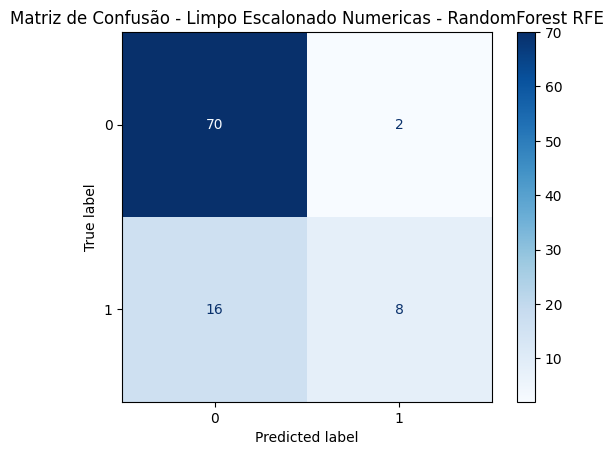


Treinando BalancedRandomForest...


/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/valeriow/des/posufg/dis008-am/.venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

--- Resultados para: Limpo Escalonado Numericas - BalancedRandomForest ---
AUC-ROC: 0.8258
AUC-PR (Precision-Recall): 0.6632
F1-Score: 0.5397
MCC: 0.3551

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.69      0.78        72
           1       0.44      0.71      0.54        24

    accuracy                           0.70        96
   macro avg       0.66      0.70      0.66        96
weighted avg       0.77      0.70      0.72        96



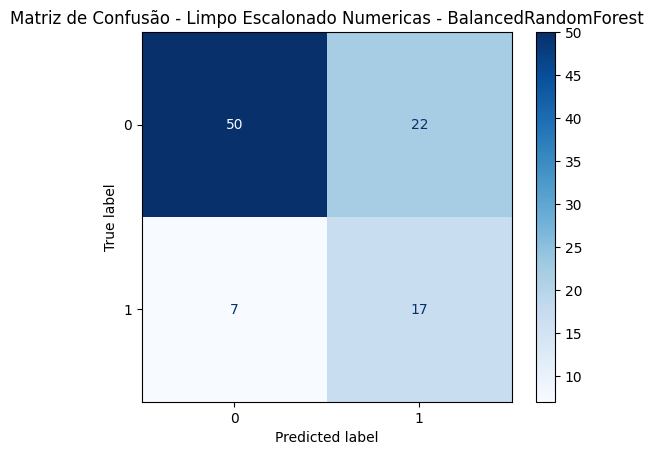


Treinando XGBoost...
[20:30:28] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Limpo Escalonado Numericas - XGBoost ---
AUC-ROC: 0.8675
AUC-PR (Precision-Recall): 0.7515
F1-Score: 0.5957
MCC: 0.4650

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        72
           1       0.61      0.58      0.60        24

    accuracy                           0.80        96
   macro avg       0.74      0.73      0.73        96
weighted avg       0.80      0.80      0.80        96



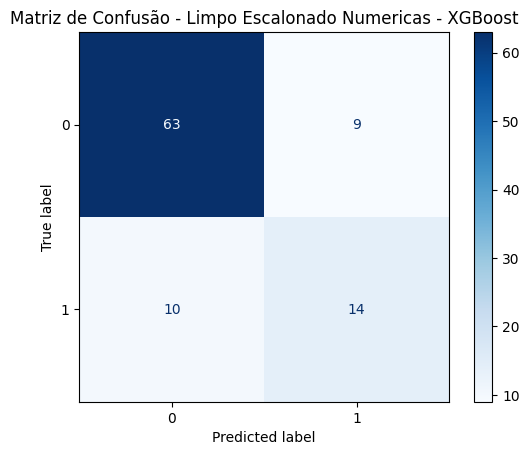


Treinando XGBoost RFE...
[20:31:12] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--- Resultados para: Limpo Escalonado Numericas - XGBoost RFE ---
AUC-ROC: 0.9016
AUC-PR (Precision-Recall): 0.8105
F1-Score: 0.6809
MCC: 0.5777

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.70      0.67      0.68        24

    accuracy                           0.84        96
   macro avg       0.79      0.78      0.79        96
weighted avg       0.84      0.84      0.84        96



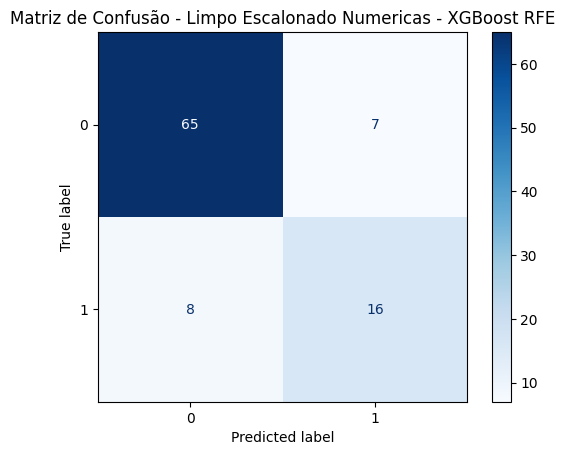


Treinando CatBoost...
--- Resultados para: Limpo Escalonado Numericas - CatBoost ---
AUC-ROC: 0.8924
AUC-PR (Precision-Recall): 0.7725
F1-Score: 0.6154
MCC: 0.5466

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        72
           1       0.80      0.50      0.62        24

    accuracy                           0.84        96
   macro avg       0.83      0.73      0.76        96
weighted avg       0.84      0.84      0.83        96



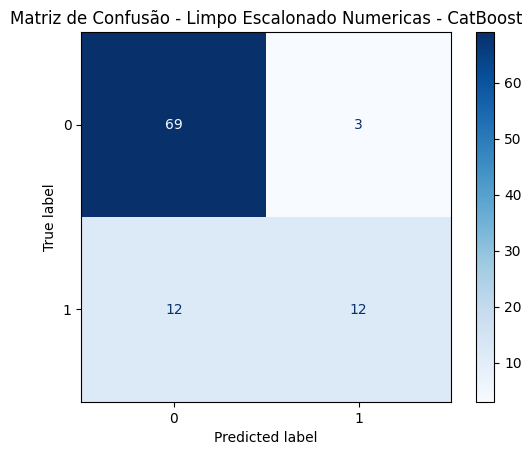


Treinando CatBoost RFE...
--- Resultados para: Limpo Escalonado Numericas - CatBoost RFE ---
AUC-ROC: 0.8779
AUC-PR (Precision-Recall): 0.7411
F1-Score: 0.5556
MCC: 0.5092

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90        72
           1       0.83      0.42      0.56        24

    accuracy                           0.83        96
   macro avg       0.83      0.69      0.73        96
weighted avg       0.83      0.83      0.81        96



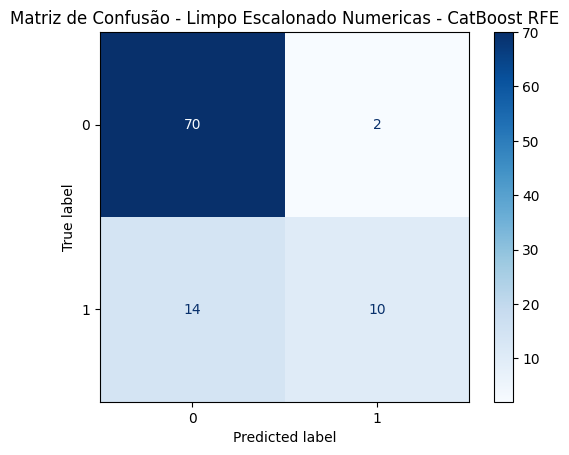


Treinando GradientBoosting...
--- Resultados para: Limpo Escalonado Numericas - GradientBoosting ---
AUC-ROC: 0.8953
AUC-PR (Precision-Recall): 0.7830
F1-Score: 0.8000
MCC: 0.7419

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        72
           1       0.86      0.75      0.80        24

    accuracy                           0.91        96
   macro avg       0.89      0.85      0.87        96
weighted avg       0.90      0.91      0.90        96



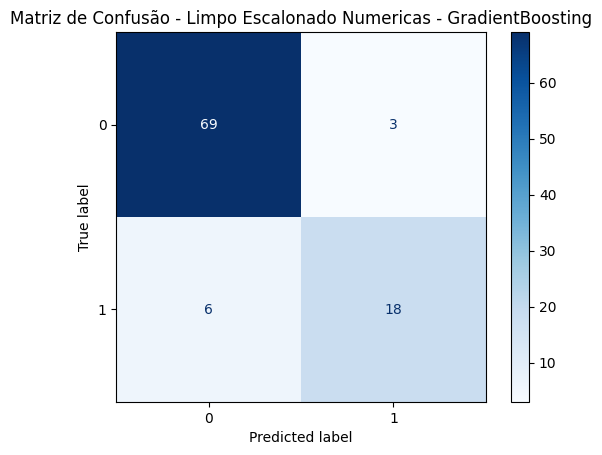


Treinando GradientBoosting RFE...
--- Resultados para: Limpo Escalonado Numericas - GradientBoosting RFE ---
AUC-ROC: 0.8970
AUC-PR (Precision-Recall): 0.7284
F1-Score: 0.6512
MCC: 0.5585

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        72
           1       0.74      0.58      0.65        24

    accuracy                           0.84        96
   macro avg       0.80      0.76      0.78        96
weighted avg       0.84      0.84      0.84        96



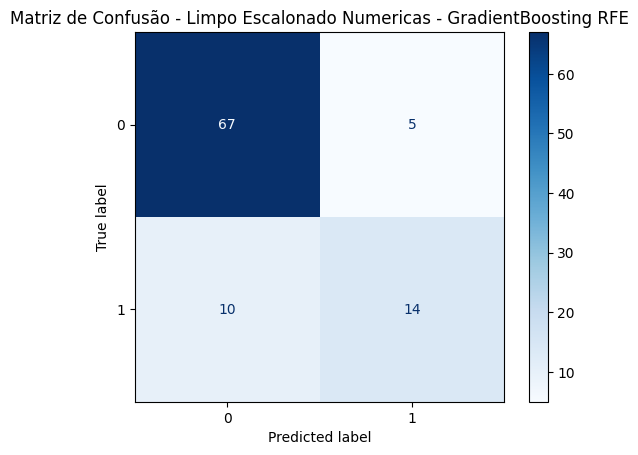

,model_name,roc_auc,pr_auc,f1,mcc
0,Limpo Escalonado Numericas - GradientBoosting,0.895255,0.783029,0.800000,0.741941
1,Limpo Escalonado Numericas - LightGBM Ponderad...,0.902778,0.809707,0.692308,0.582182
2,Limpo Escalonado Numericas - LightGBM SMOTE Po...,0.874421,0.766945,0.692308,0.582182
3,Limpo Escalonado Numericas - LightGBM RFE,0.900463,0.805222,0.680851,0.577694
4,Limpo Escalonado Numericas - LightGBM SMOTE RFE,0.900463,0.805222,0.680851,0.577694
5,Limpo Escalonado Numericas - XGBoost RFE,0.901620,0.810497,0.680851,0.577694
6,Limpo Escalonado Numericas - GradientBoosting RFE,0.896991,0.728421,0.651163,0.558495
7,Limpo Escalonado Numericas - RUSBoost,0.874421,0.754478,0.666667,0.557668
8,Limpo Escalonado Numericas - LightGBM Ponderado,0.901042,0.818408,0.666667,0.548424
9,Limpo Escalonado Numericas - CatBoost,0.892361,0.772490,0.615385,0.546594


In [12]:
# Treinar e avaliar modelos nos dados limpos com escalonamento nas features numéricas
resultados = []
X_train_cleaned, X_val_cleaned, y_train_cleaned, y_val_cleaned = split_data(X_cleaned, y)

numeric_cols, categorical_cols = get_numeric_categoric_features(X_train_cleaned)
preprocessor = ColumnTransformer([
    ('num_normal', StandardScaler(), numeric_cols),
    #('num_skewed', PowerTransformer(method='yeo-johnson'), skewed_features),
    #('cat_nominal', OneHotEncoder(drop='first'), nominal_features),
    #('cat_ordinal', OrdinalEncoder(), ordinal_features)
], remainder='passthrough') # Mantém as colunas não especificadas inalteradas

for descricao_dataset, model_name, model in prepara_modelos(descricao_dataset="Limpo Escalonado Numericas", preprocessor=preprocessor):
    print(f"\nTreinando {model_name}...")
    model.fit(X_train_cleaned, y_train_cleaned)
    resultado = avaliar_modelo(model, X_val_cleaned, y_val_cleaned, model_name=f"{descricao_dataset} - {model_name}")
    resultados.append(resultado)

df_temp = pd.DataFrame(resultados).sort_values('mcc', ascending=False).reset_index(drop=True)
resultados_dfs.append(df_temp)
df_temp

Percecemos uma melhora sutil nos modelos quando usado o dataset pre-processado no lugar do original. A melhora mais perceptível é nos modelos de regressão logística, como esperado, pois são mais sensíveis a colinearidade e escala. Já nos modelos basedos em árvores de decisão a melhoria foi bem mais sutil, mas importante, evidenciando que uma boa engenharia de features é importante.

Isso evidencia a importância da Análise Exploratória de Dados (AED). Mesmo não tendo especialistas do domínio específico de aplicação, foi possível identificar características das features a partir da AED e fazer o tratamento adequado para que os modelos tenham um desempenho melhor.


In [13]:
# Combinar os dois dataframes de resultados
#df_resultados_combinado = pd.concat([df_resultados_original, df_resultados_cleaned], ignore_index=True)

#df_resultados_combinado = df_resultados_combinado.sort_values('mcc', ascending=False).reset_index(drop=True)
# Ordenar pela coluna mcc em ordem decrescente

#df_resultados_combinado

In [14]:
# Combinar os dois dataframes de resultados

df_resultados_combinado = pd.concat(resultados_dfs, ignore_index=True)

df_resultados_combinado = df_resultados_combinado.sort_values('mcc', ascending=False).reset_index(drop=True)
# Ordenar pela coluna mcc em ordem decrescente

df_resultados_combinado

,model_name,roc_auc,pr_auc,f1,mcc
0,Limpo Escalonado Numericas - GradientBoosting,0.895255,0.783029,0.800000,0.741941
1,Limpo Escalonado Geral - GradientBoosting,0.888310,0.744104,0.755556,0.683749
2,Original - XGBoost RFE,0.910301,0.810931,0.745098,0.655434
3,Original Escalonado - XGBoost RFE,0.910301,0.810931,0.745098,0.655434
4,Limpo - LightGBM SMOTE Ponderado RFE,0.893519,0.754475,0.727273,0.630228
...,...,...,...,...,...
125,Limpo - Regressão Logística,0.508102,0.305988,0.400000,0.000000
126,Limpo - LogisticRegression Ponderado,0.508102,0.305988,0.400000,0.000000
127,Limpo - KNN,0.561343,0.270848,0.071429,0.000000
128,Original Escalonado - KNN,0.571181,0.275337,0.071429,0.000000


In [15]:
df_resultados_combinado.sort_values('roc_auc', ascending=False).reset_index(drop=True)

,model_name,roc_auc,pr_auc,f1,mcc
0,Original - GradientBoosting,0.914931,0.810432,0.697674,0.618872
1,Original Escalonado - GradientBoosting,0.914931,0.810432,0.697674,0.618872
2,Original - XGBoost RFE,0.910301,0.810931,0.745098,0.655434
3,Original Escalonado - XGBoost RFE,0.910301,0.810931,0.745098,0.655434
4,Limpo Escalonado Geral - GradientBoosting RFE,0.905093,0.744762,0.634146,0.551403
...,...,...,...,...,...
125,Original - LogisticRegression Ponderado,0.508102,0.305988,0.400000,0.000000
126,Original - Regressão Logística,0.508102,0.305988,0.400000,0.000000
127,Limpo - Regressão Logística,0.508102,0.305988,0.400000,0.000000
128,Limpo - LogisticRegression Ponderado,0.508102,0.305988,0.400000,0.000000


In [16]:
df_resultados_combinado.sort_values('pr_auc', ascending=False).reset_index(drop=True)

,model_name,roc_auc,pr_auc,f1,mcc
0,Original - LightGBM Ponderado,0.896991,0.822588,0.692308,0.582182
1,Original Escalonado - LightGBM Ponderado,0.896991,0.822588,0.692308,0.582182
2,Limpo Escalonado Numericas - LightGBM Ponderado,0.901042,0.818408,0.666667,0.548424
3,Limpo Escalonado Geral - LightGBM Ponderado,0.901042,0.818408,0.666667,0.548424
4,Limpo - LightGBM Ponderado,0.901042,0.818408,0.666667,0.548424
...,...,...,...,...,...
125,Limpo - LogisticRegression Ponderado,0.508102,0.305988,0.400000,0.000000
126,Limpo Escalonado Numericas - Regressão Logística,0.508102,0.305988,0.400000,0.000000
127,Original - KNN,0.571181,0.275337,0.071429,0.000000
128,Original Escalonado - KNN,0.571181,0.275337,0.071429,0.000000
